# DBSCAN Cluster

In [1]:
%matplotlib inline

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import silhouette_score
from tqdm import tqdm
from sklearn.decomposition import PCA
from sklearn import metrics
from sklearn.cluster import DBSCAN
from scipy.spatial.distance import pdist, squareform
from clustering_utils import *

## Load the Data

In [2]:
df = pd.read_csv("dataset/cleaned_user_profiles.csv", index_col=0)

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 11508 entries, 2353593986 to 933183398
Data columns (total 17 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   name                    11508 non-null  object 
 1   lang                    11508 non-null  object 
 2   bot                     11508 non-null  int64  
 3   created_at              11508 non-null  object 
 4   statuses_count          11508 non-null  int64  
 5   avg_length              11508 non-null  float64
 6   avg_special_chars       11508 non-null  float64
 7   urls_ratio              11508 non-null  float64
 8   mentions_ratio          11508 non-null  float64
 9   hashtags_ratio          11508 non-null  float64
 10  reply_count_mean        11508 non-null  float64
 11  reply_count_std         11508 non-null  float64
 12  favorite_count_mean     11508 non-null  float64
 13  favorite_count_std      11508 non-null  float64
 14  favorite_count_entropy  1

loaded the data, we separate the numerical features (used to run the clustering algorithms) and the categorical ones (used to understand the results of the clustering algorithms)

In [4]:
# remove categorical features
cat_features = ["name", "lang", "bot", "created_at"]
df_cat = df[cat_features]
df_num = df.loc[:, ~df.columns.isin(cat_features)]

In [5]:
df_cat.head()

name lang  bot           created_at
2353593986   Lamonica Raborn   en    1  2019-02-22 18:00:42
2358850842     Lourie Botton   en    0  2019-02-26 03:02:32
137959629   Dadan Syarifudin   en    1  2015-04-30 07:09:56
466124818     Carletto Focia   it    1  2017-01-18 02:49:18
2571493866         MBK Ebook   en    0  2019-06-18 19:30:21

In [6]:
df_num.head()

statuses_count  avg_length  avg_special_chars  urls_ratio  \
2353593986              76   62.340909          14.015152    0.000000   
2358850842              54   69.082645          15.041322    0.000000   
137959629               53   65.340909          14.694444    0.000000   
466124818               50   86.944871          18.689463    0.022331   
2571493866            7085   72.311246          14.582073    0.000825   

            mentions_ratio  hashtags_ratio  reply_count_mean  reply_count_std  \
2353593986        0.272727        0.098485               0.0              0.0   
2358850842        0.338843        0.024793               0.0              0.0   
137959629         0.000000        0.000000               0.0              0.0   
466124818         0.006281        0.072575               0.0              0.0   
2571493866        0.506461        0.118229               0.0              0.0   

            favorite_count_mean  favorite_count_std  favorite_count_entropy  \
2353593986             0.037879            0.190903                0.232481   
2358850842             0.049587            0.217090                0.284639   
137959629              0.000000            0.000000                0.000000   
466124818              0.165387            0.530838                0.669155   
2571493866             0.056365            0.243387                0.317182   

            retweet_count_mean  retweet_count_std  
2353593986            0.037879           0.190903  
2358850842            0.024793           0.155495  
137959629             0.000000           0.000000  
466124818             0.826239          13.034008  
2571493866            0.016772           0.142619

## Preprocessing

First apply the log scale of the feature with a skewed distribution (see DataProfileUnderstanding.ipynb), following the results presented in data understanding of the profiling.

In [7]:
# TODO : Review the DataUnderstandingProfiling

skewed_features = [
    "statuses_count",
    "avg_special_chars",
    "urls_ratio",
    "mentions_ratio",
    "hashtags_ratio",
    "reply_count_mean",
    "reply_count_std",
    "favorite_count_mean",
    "favorite_count_std",
    "retweet_count_mean",
    "retweet_count_std"]

df_num_not_skewed = preprocess_skewed_features(df_num, skewed_features)

Apply Standard Scaling as preprocessing step

In [8]:
scaler = StandardScaler()

In [9]:
X = scaler.fit_transform(df_num_not_skewed.values)

## Apply DBSCAN Clustering

To choose the best parameters for the dbscan clustering method we will try different combinations of the epsilon and neigbohrs.

First compute the distances matrix.

In [10]:
dist = pdist(X, 'euclidean') #pair wise distance
print (dist[0])
dist = squareform(dist) #distance matrix given the vector dist
print()
print(dist)

1.3429762633566766

[[0.         1.34297626 2.13727623 ... 3.51381364 1.53612698 3.95049739]
 [1.34297626 0.         1.83523055 ... 4.46107725 0.81833692 4.11033573]
 [2.13727623 1.83523055 0.         ... 4.8638963  2.15207068 5.03984859]
 ...
 [3.51381364 4.46107725 4.8638963  ... 0.         4.8507402  6.45222495]
 [1.53612698 0.81833692 2.15207068 ... 4.8507402  0.         3.72267213]
 [3.95049739 4.11033573 5.03984859 ... 6.45222495 3.72267213 0.        ]]


Let's compute the distances from the k-th neighbor and plotting out the values for each sample in the dataset

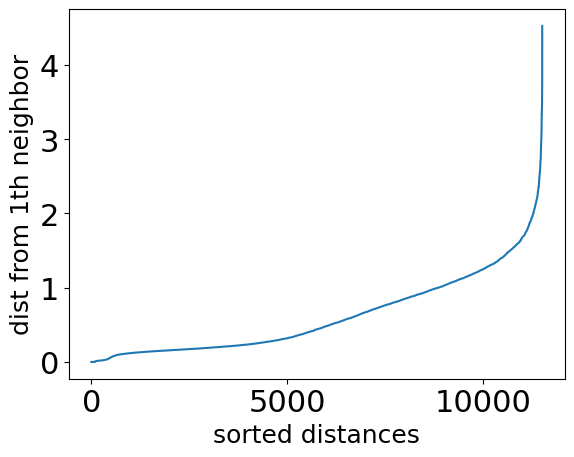

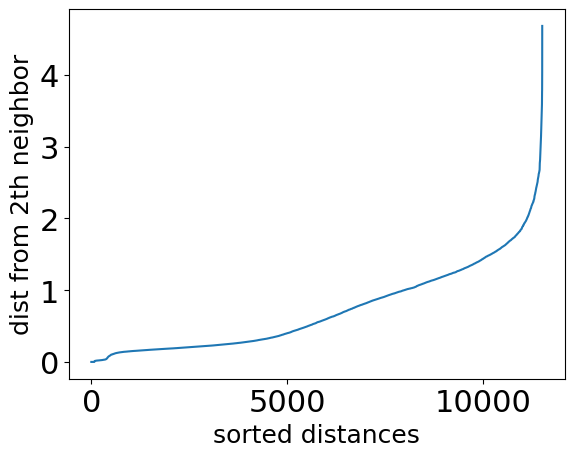

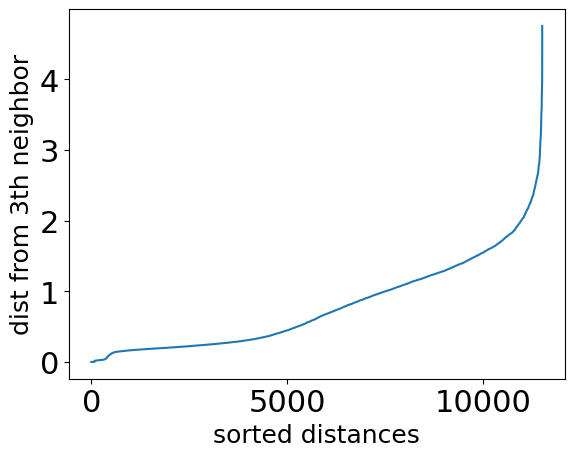

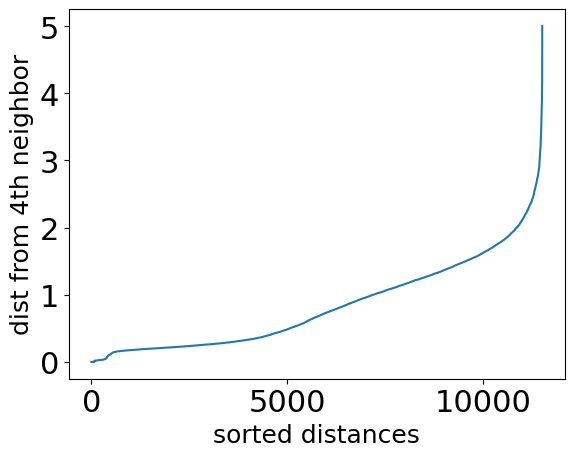

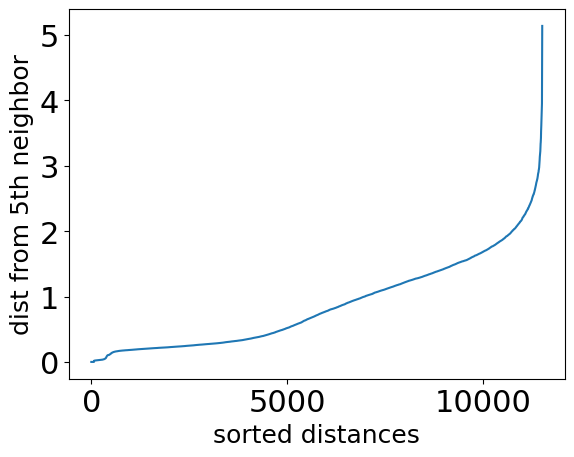

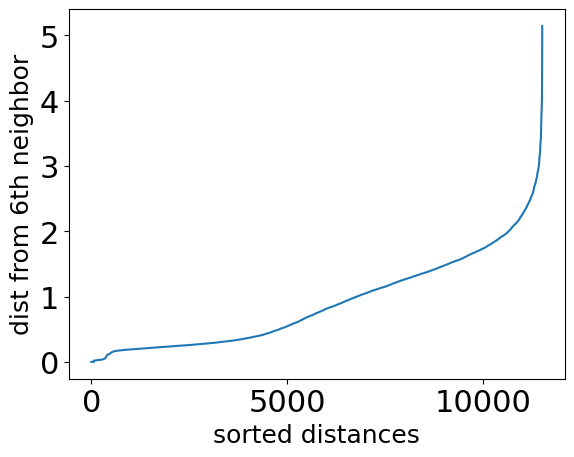

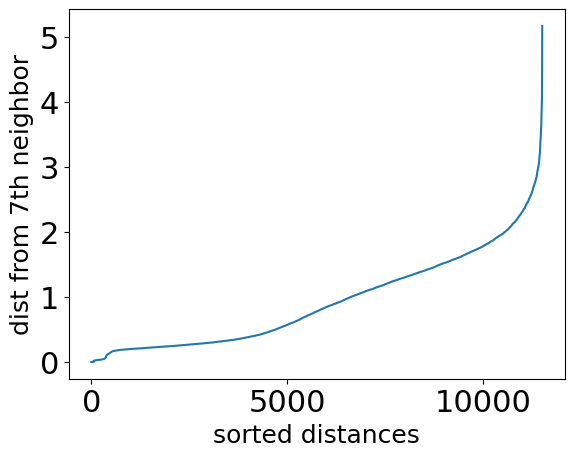

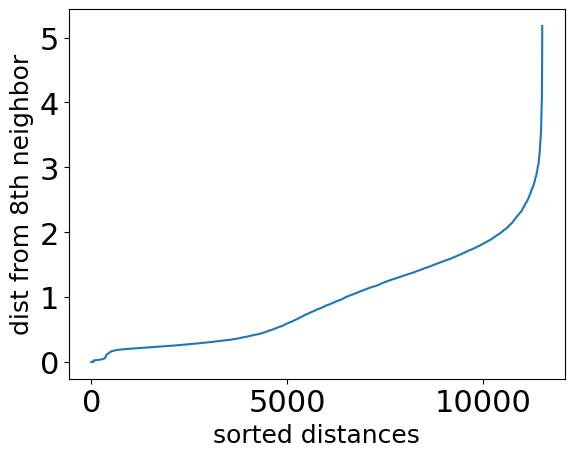

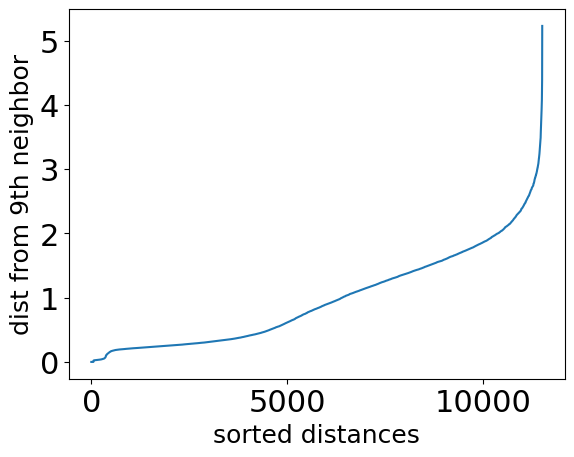

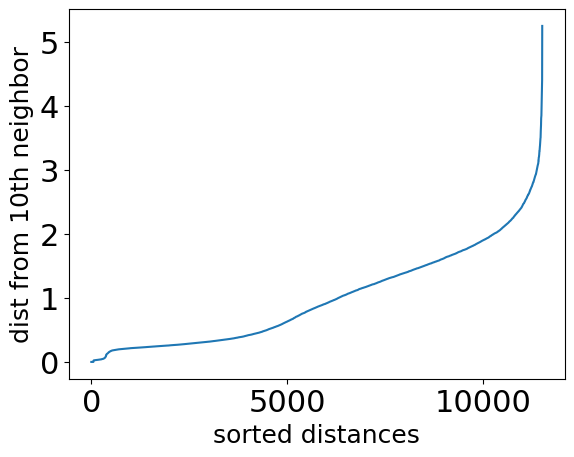

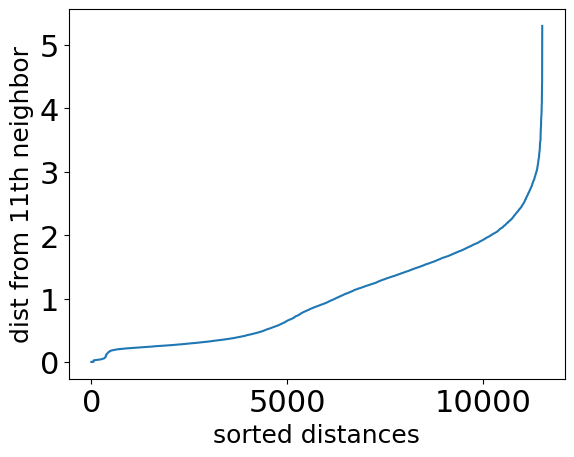

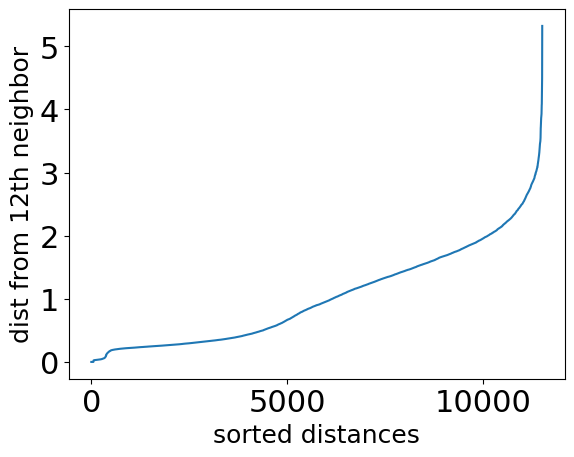

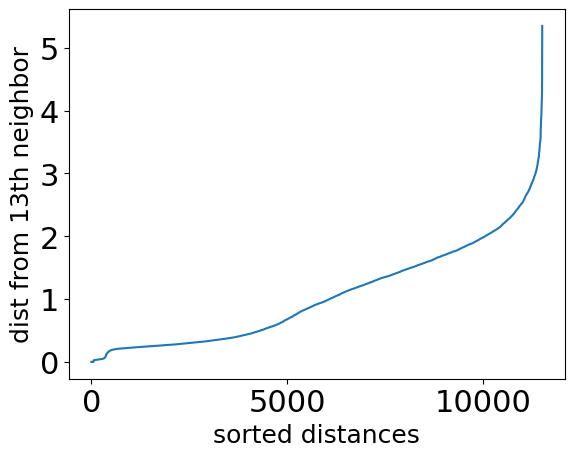

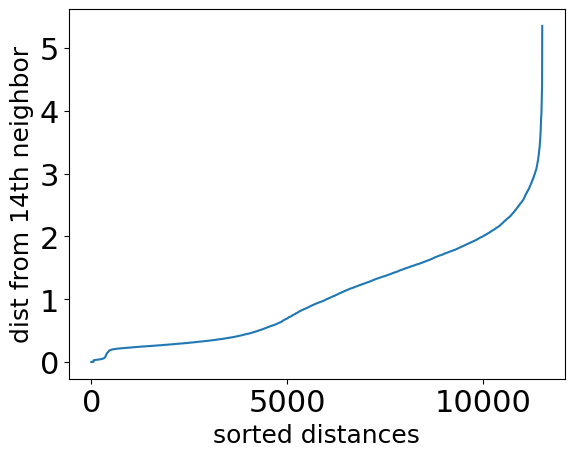

In [11]:
for k in range (1, 15):
    kth_distances = list()
    for d in dist:
        index_kth_distance = np.argsort(d)[k]
        kth_distances.append(d[index_kth_distance])
    plt.plot(range(0, len(kth_distances)), sorted(kth_distances))
    plt.ylabel('dist from %sth neighbor' % k, fontsize=18)
    plt.xlabel('sorted distances', fontsize=18)
    plt.tick_params(axis='both', which='major', labelsize=22)
    #plt.axhline(y=1.7)
    plt.show()

For each curve select the distances that optimize the ELBO

In [12]:
dbscan = []
counter = 0
# choose best distance according to the plots,
# taking out the distance that represent the point just before the exponential increasing of the curve
# best_distance = [1.3, 1.45, 1.5, 1.55, 1.6, 1.75, 1.8, 1.9, 2, 2.1, 2.2, 2.3, 2.4]

best_distance = [1.2, 1.3, 1.4, 1.5, 1.6, 1.7, 1.8, 1.9, 2, 2.1, 2.2, 2.3, 2.4]

for i in best_distance:
    dbscan.append(DBSCAN(eps=i, min_samples=counter + 2).fit(X))
    counter += 1

In [13]:
# compute and print the number of clusters found by the DBSCAN runs
counter_i = 0
for i in dbscan:
    counter_j = 0
    print("DBSCAN with " + str(counter_i + 2) + " neighbors:\n", "Noise Points: " + str(np.unique(i.labels_, return_counts=True)[1][0]) + "\n", "Points in the other clusters:")
    for j in np.unique(i.labels_, return_counts=True)[1]:
        if counter_j != 0:
            print("Cluster " +  str(counter_j) + ": " + str(j) + "   ", end = '')
            if counter_j % 5 == 0:
                print("")
        counter_j += 1
    print("\n")
    counter_i += 1

DBSCAN with 2 neighbors:
 Noise Points: 1703
 Points in the other clusters:
Cluster 1: 8163   Cluster 2: 2   Cluster 3: 473   Cluster 4: 23   Cluster 5: 5   
Cluster 6: 153   Cluster 7: 13   Cluster 8: 2   Cluster 9: 3   Cluster 10: 3   
Cluster 11: 3   Cluster 12: 79   Cluster 13: 2   Cluster 14: 2   Cluster 15: 6   
Cluster 16: 3   Cluster 17: 10   Cluster 18: 111   Cluster 19: 2   Cluster 20: 5   
Cluster 21: 2   Cluster 22: 2   Cluster 23: 7   Cluster 24: 3   Cluster 25: 2   
Cluster 26: 5   Cluster 27: 104   Cluster 28: 3   Cluster 29: 6   Cluster 30: 2   
Cluster 31: 2   Cluster 32: 5   Cluster 33: 3   Cluster 34: 2   Cluster 35: 2   
Cluster 36: 5   Cluster 37: 6   Cluster 38: 3   Cluster 39: 4   Cluster 40: 2   
Cluster 41: 2   Cluster 42: 2   Cluster 43: 3   Cluster 44: 4   Cluster 45: 2   
Cluster 46: 2   Cluster 47: 4   Cluster 48: 2   Cluster 49: 2   Cluster 50: 2   
Cluster 51: 3   Cluster 52: 3   Cluster 53: 2   Cluster 54: 8   Cluster 55: 3   
Cluster 56: 2   Cluster 57:

In [14]:
# compute and print the silouette and the Separation of the DBSCAN runs
for num_neig, dbscan_sample in enumerate(dbscan, 2):
    print(f'Silhouette with {num_neig} neigs : {silhouette_score(X, dbscan_sample.labels_)}')
    print(f'Separation with {num_neig} neigs : {metrics.davies_bouldin_score(X, dbscan_sample.labels_)}')
    print()

Silhouette with 2 neigs : -0.2550722293357945
Separation with 2 neigs : 1.271133676617844

Silhouette with 3 neigs : -0.19450932366237123
Separation with 3 neigs : 1.3837206319238011

Silhouette with 4 neigs : -0.14002958905280222
Separation with 4 neigs : 1.4201457297418965

Silhouette with 5 neigs : -0.11293616442308071
Separation with 5 neigs : 1.552986719566508

Silhouette with 6 neigs : 0.03714967127298556
Separation with 6 neigs : 1.5912030902771894

Silhouette with 7 neigs : 0.0532273242396535
Separation with 7 neigs : 1.7505356990686054

Silhouette with 8 neigs : 0.058257717481192094
Separation with 8 neigs : 1.7968980264609355

Silhouette with 9 neigs : 0.12579307613236934
Separation with 9 neigs : 2.06934219241143

Silhouette with 10 neigs : 0.23563292436694222
Separation with 10 neigs : 2.6888891093222704

Silhouette with 11 neigs : 0.23800773634409955
Separation with 11 neigs : 2.6932365614034572

Silhouette with 12 neigs : 0.23797395335807042
Separation with 12 neigs : 2.7

Select out the best combination of parameters, in this case we have choose the method that produce only two clusters, the one with 11 neighbors and distance as 2.1, since the other runs produce cluster too small, and for the first runs even too much little clusters

In [15]:
result = dbscan[-4]
num_clusters = 3 # even the noise cluster

In [16]:
#aggiungo ogni elemento nel proprio cluster di appartenenza, eliminando i punti di noise
clusters = []
pos = 0
for i in range (num_clusters):
    clusters.append(list())
for i in (result.labels_):
    clusters[i].append(X[pos])
    pos = pos + 1

In [17]:
#computes centroids for each cluster
centroids = list()
for cluster in clusters:
    x_ = np.zeros(X.shape[1])
    for i in cluster:
        x_ += i
    x_ /= len(cluster)    
    
    centroids.append(x_)

Plot The number of samples in each cluster

In [35]:
hist, bins = np.histogram(result.labels_,
                          bins=range(-1, len(set(result.labels_))))
dict(zip(bins, hist))

{-1: 405, 0: 10749, 1: 354}

### Plot Cluster Results

Plot the centroids in a tabular way, to have a summary of the clusters

In [42]:
pd.DataFrame(centroids, columns=df_num.columns, index=np.unique(result.labels_))

statuses_count  avg_length  avg_special_chars  urls_ratio  mentions_ratio  \
-1       -0.046342   -0.014340          -0.001582   -0.050348       -0.050178   
 0        0.989510   -0.256424          -0.368697    0.229811        0.725435   
 1        0.365056    0.604730           0.364244    1.135409        0.697672   

    hashtags_ratio  reply_count_mean  reply_count_std  favorite_count_mean  \
-1       -0.012699         -0.002493        -0.000256            -0.018130   
 0       -0.282518         -0.251898        -0.348794            -0.341524   
 1        0.583984          0.286336         0.311665             0.779694   

    favorite_count_std  favorite_count_entropy  retweet_count_mean  \
-1           -0.111805               -0.128291           -0.057515   
 0            2.279796                2.907086            1.169709   
 1            0.974669                0.863926            0.504083   

    retweet_count_std  
-1          -0.063189  
 0           1.097421  
 1           0.717862

In [20]:
centers = reverse_log_skewed(scaler.inverse_transform(centroids), df_num, skewed_features)

In [43]:
pd.DataFrame(centers, columns=df_num.columns, index=np.unique(result.labels_))

statuses_count  avg_length  avg_special_chars  urls_ratio  mentions_ratio  \
-1      198.268692   66.917231          14.856373    0.027228        0.280215   
 0     2387.405436   63.829519          13.991437    0.041418        0.524309   
 1      533.371220   74.813313          15.767908    0.088640        0.514817   

    hashtags_ratio  reply_count_mean  reply_count_std  favorite_count_mean  \
-1        0.085428          0.001918         0.021874             0.077554   
 0        0.067216          0.000005         0.000164             0.045752   
 1        0.126815          0.004137         0.041702             0.160208   

    favorite_count_std  favorite_count_entropy  retweet_count_mean  \
-1            0.282085                0.335296            0.514618   
 0            1.334281                1.521401            2.856960   
 1            0.683212                0.723015            1.323105   

    retweet_count_std  
-1           2.689389  
 0          24.417766  
 1          12.521433

Plot the centroids coordinates in parallel and radar coordinates, we can see that the different centroids have values of the features that vary in the magnitude between different clusters, so each cluster represent a kind of behaviour different with respect the others.

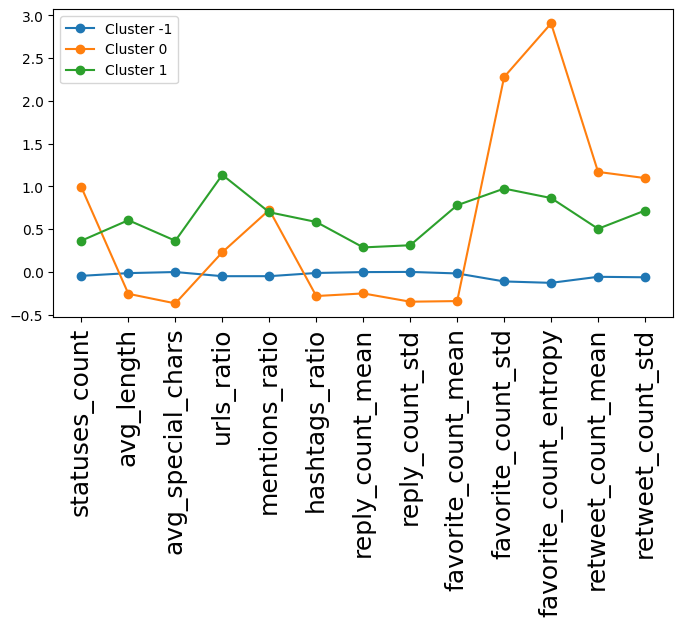

In [47]:
plt.figure(figsize=(8, 4))
for i in range(0, len(centroids)):
    plt.plot(centroids[i], marker='o', label='Cluster %s' % np.unique(result.labels_)[i])
plt.tick_params(axis='both', which='major', labelsize=10)
plt.xticks(range(0, len(df_num.columns)), df_num.columns, fontsize=18, rotation=90)
plt.legend(fontsize=10)
plt.savefig(f"images/clustering/dbscan_parallel.png")
plt.show()

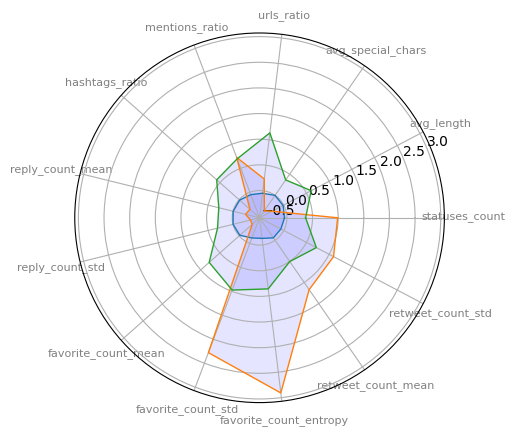

In [23]:
plot_radar_clusters(df_num, centroids, "dbscan")

#### Distribution of CategoricalFeatures per Cluster

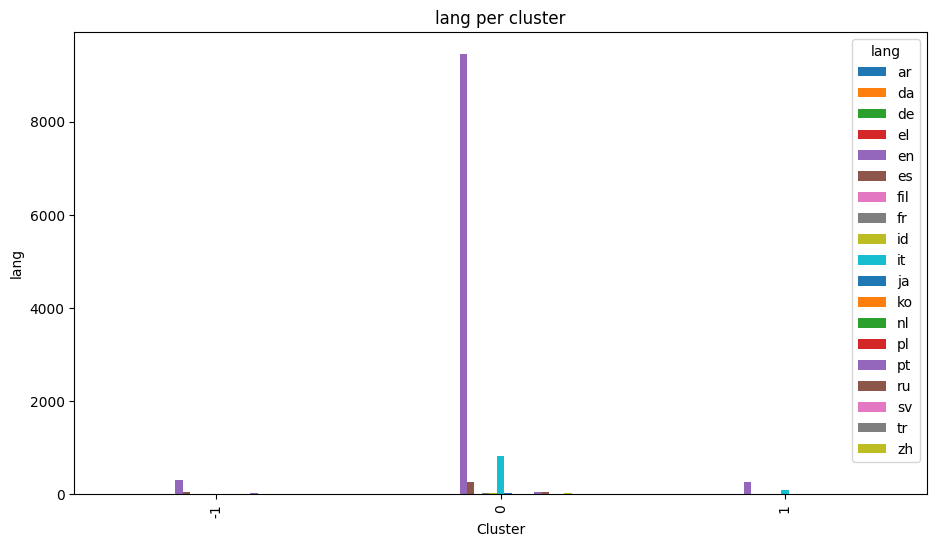

In [24]:
categorical_hist_clusters(df_cat, result.labels_, "lang", "dbscan")

Plot the distribution of bot and non-bot user per cluster, we can see that each cluster have, more or less, the same number of the two classes, this is radically different w.r.t. the other clustering methods.

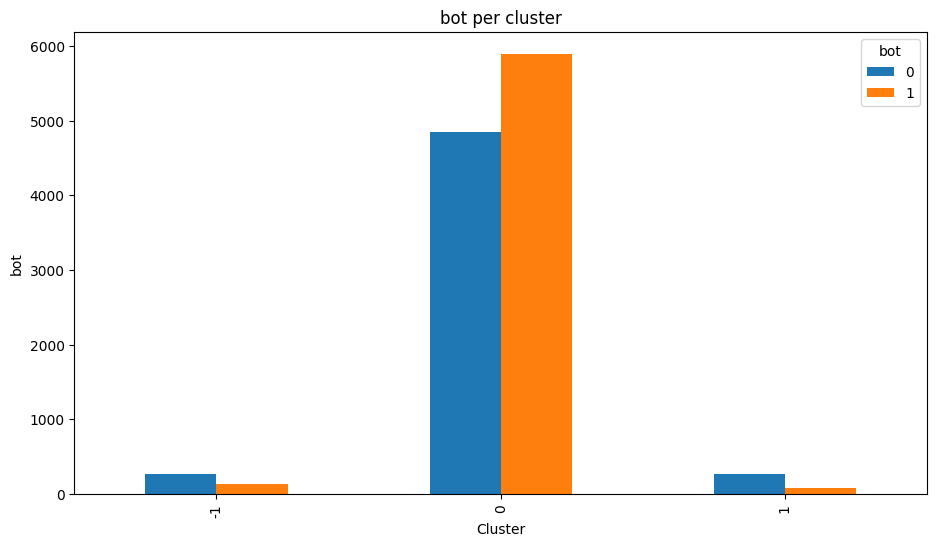

In [25]:
categorical_hist_clusters(df_cat, result.labels_, "bot", "dbscan")

compute the entropy of the feature bot in each cluster

In [26]:
entropy_clusters(df_cat, result.labels_, "bot")

labels
-1    0.643142
 0    0.688432
 1    0.537839
Name: bot, dtype: float64

Plot of the **created_at** feature (grouped by year) of the user in each cluster

-1
405


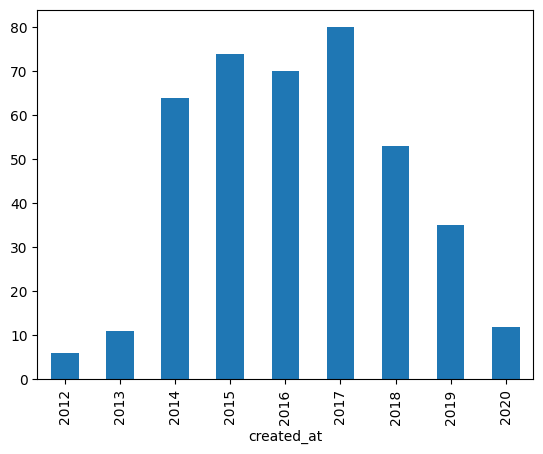

0
10749


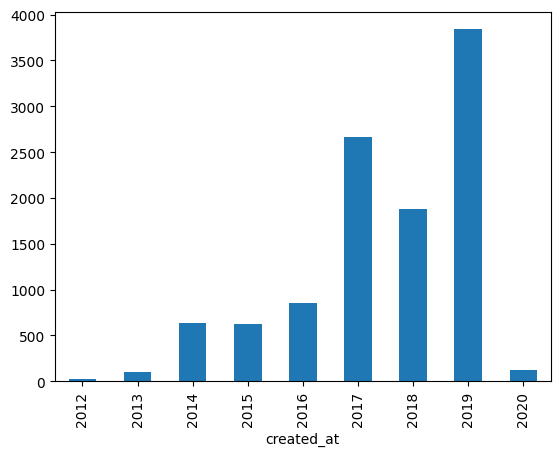

1
354


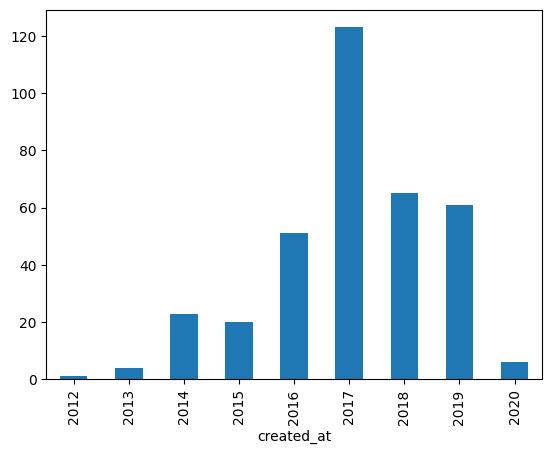

In [27]:
for i in np.unique(result.labels_):
    i_samples = result.labels_==i
    print(i)
    print(np.sum(i_samples))
    df[i_samples].name.groupby(pd.to_datetime(df.loc[i_samples, 'created_at'], format='%Y-%m-%d %H:%M:%S', errors='raise').dt.year).count().plot(kind="bar")
    plt.show()

#### Distribution of Numerical Features per Cluster

We will plot the distribution of the variables in the original space, plotting the boxplots and histogram of each numerical feature for each discovered cluster.

Cluster: -1


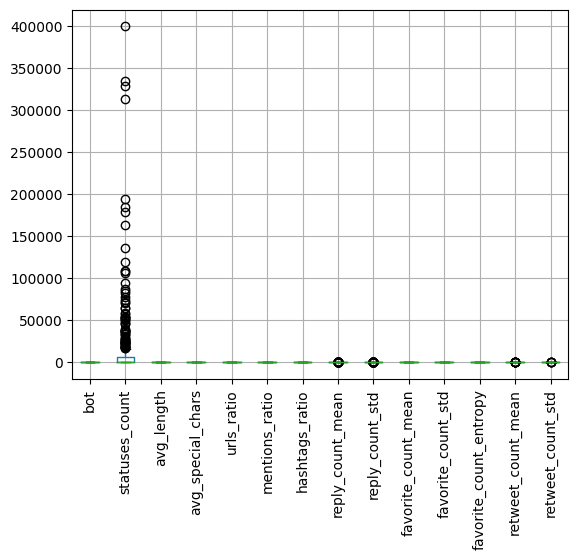

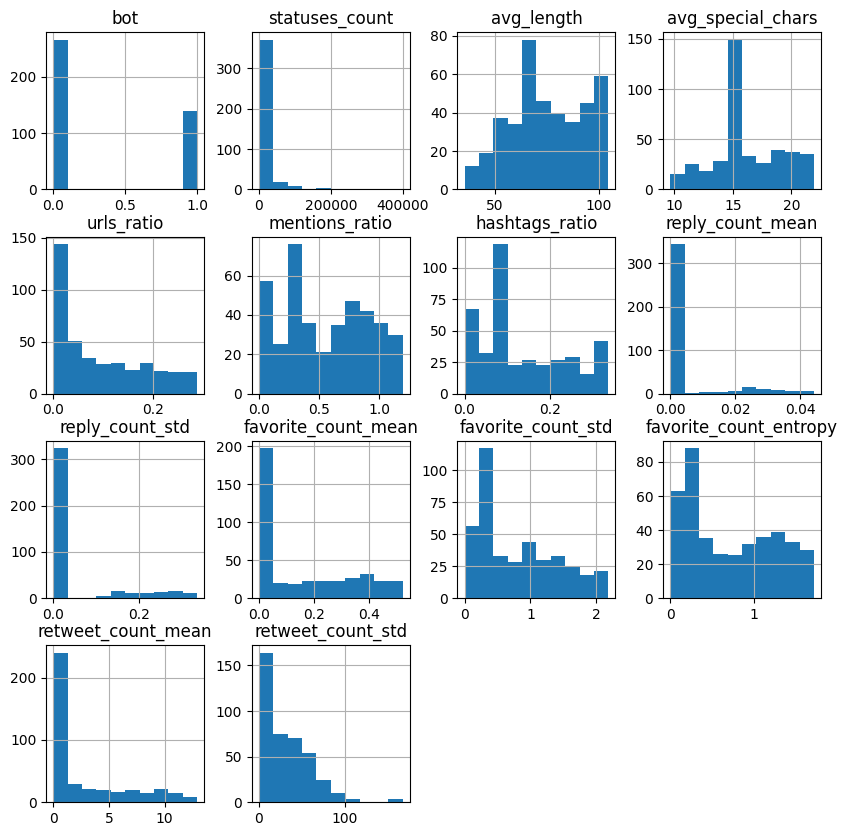

Cluster: 0


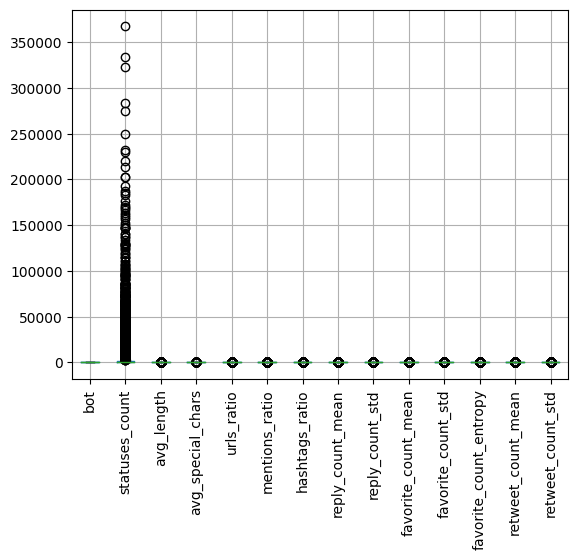

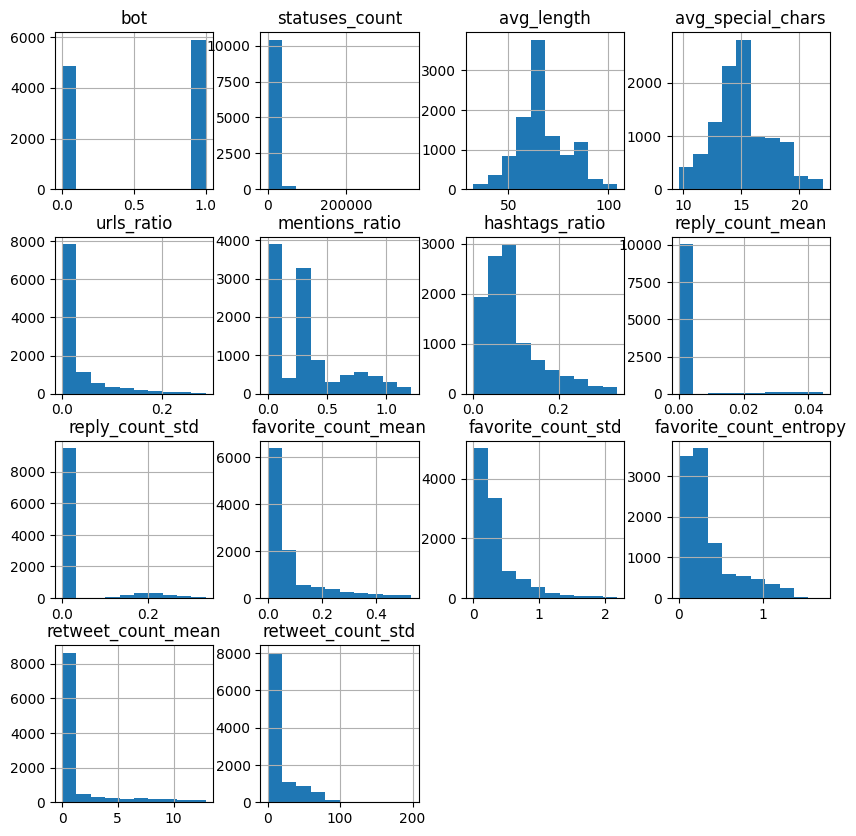

Cluster: 1


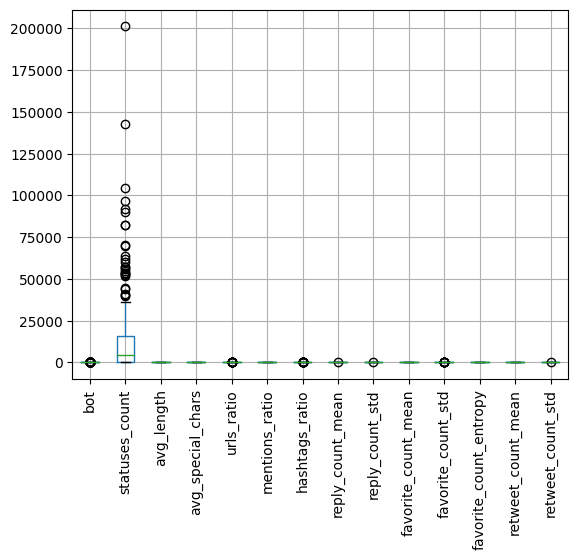

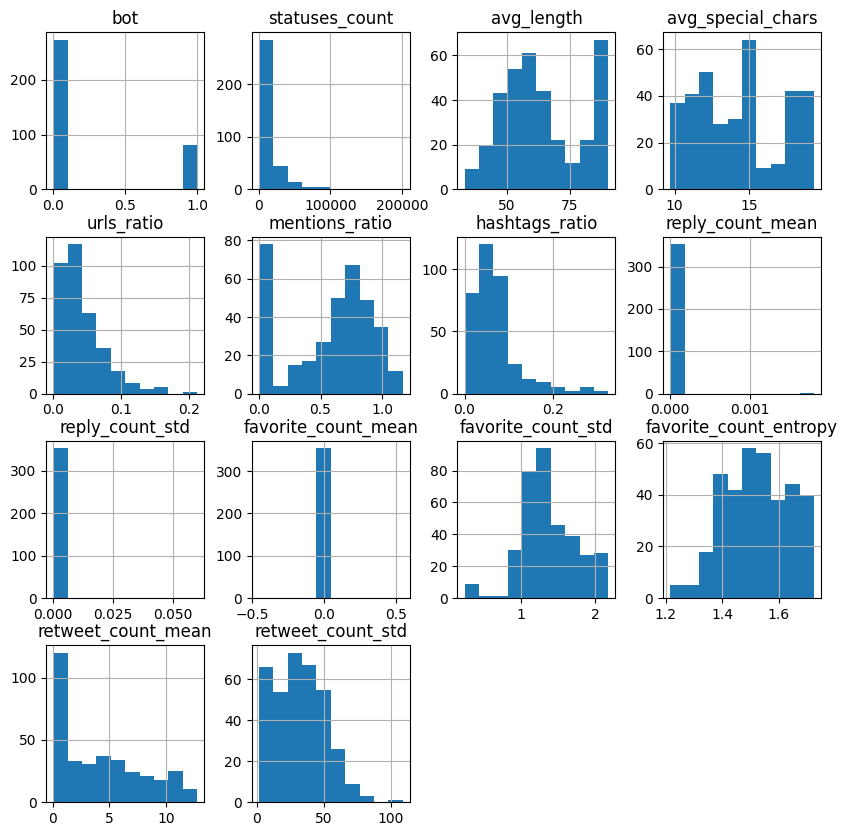

In [28]:
for i in np.unique(result.labels_):
    print(f"Cluster: {i}")
    i_samples = result.labels_==i
    df[i_samples].boxplot()
    plt.xticks(rotation=90)
    df[i_samples].hist(figsize=(10,10))
    plt.xticks(rotation=90)
    plt.show()

Plotting the scatter plot of each pair of numerical features, coloring out the points with respect the cluster number of each sample

statuses_count - avg_length


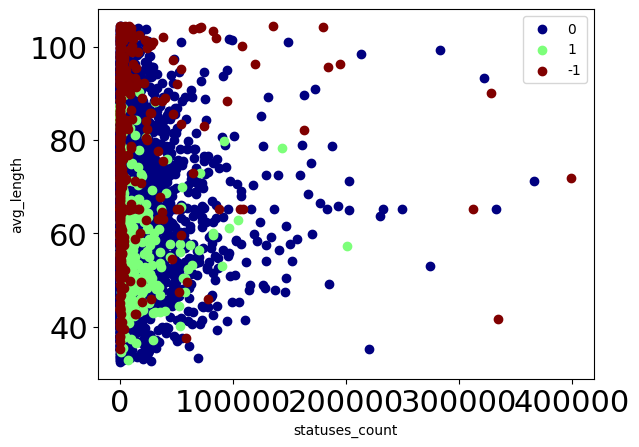

statuses_count - avg_special_chars


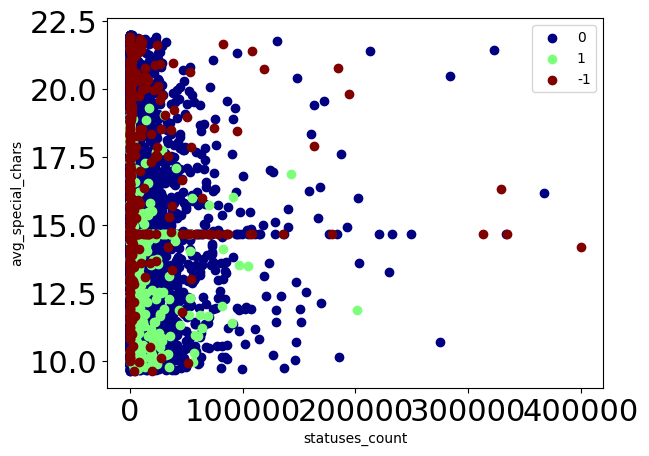

statuses_count - urls_ratio


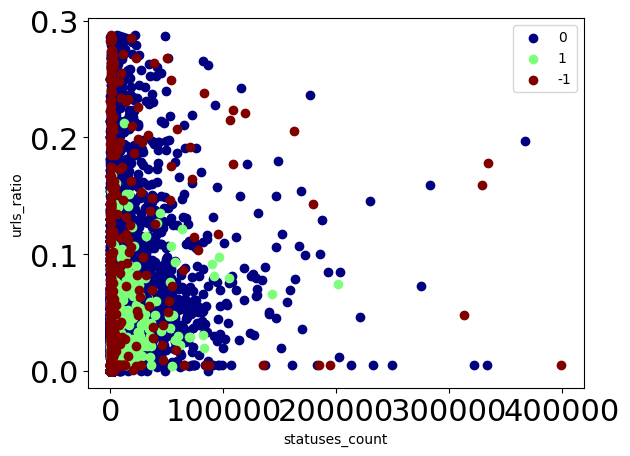

statuses_count - mentions_ratio


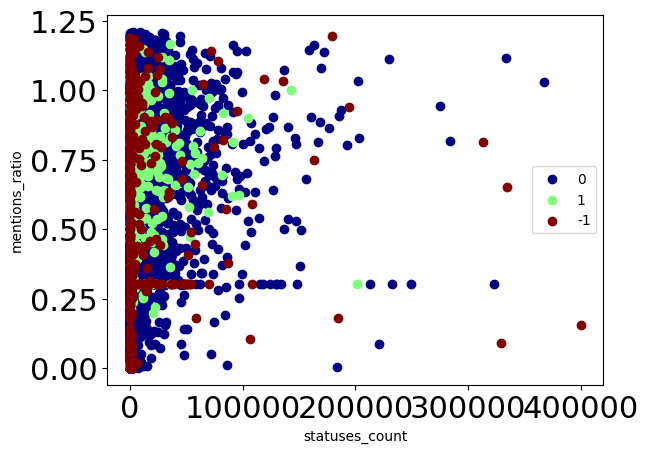

statuses_count - hashtags_ratio


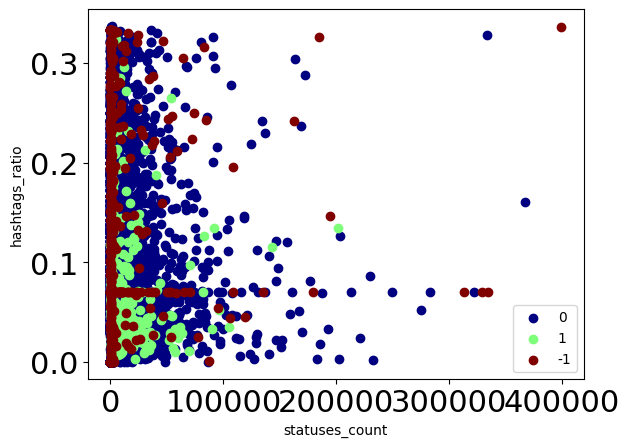

statuses_count - reply_count_mean


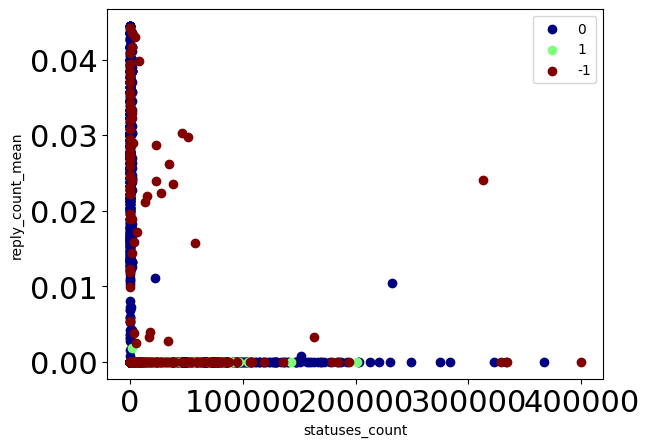

statuses_count - reply_count_std


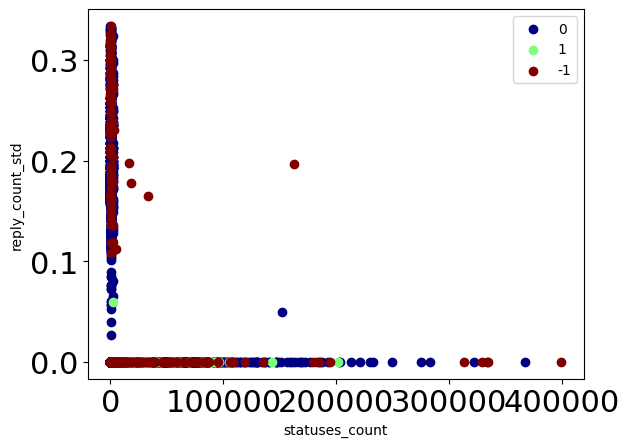

statuses_count - favorite_count_mean


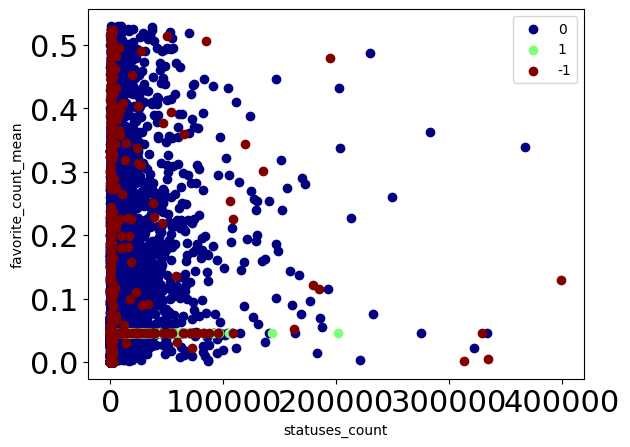

statuses_count - favorite_count_std


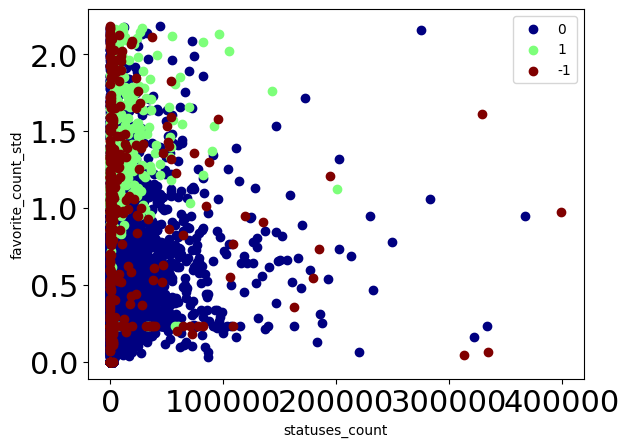

statuses_count - favorite_count_entropy


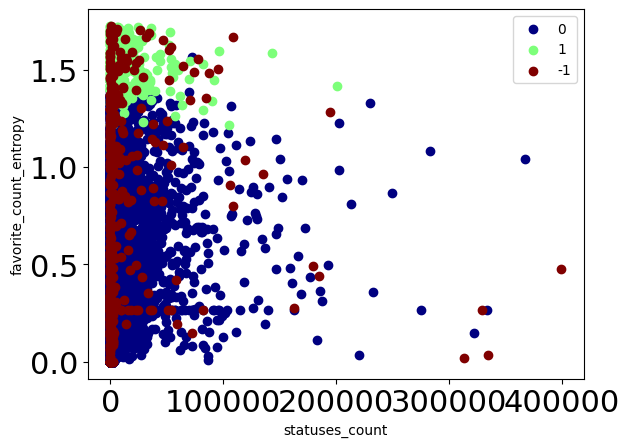

statuses_count - retweet_count_mean


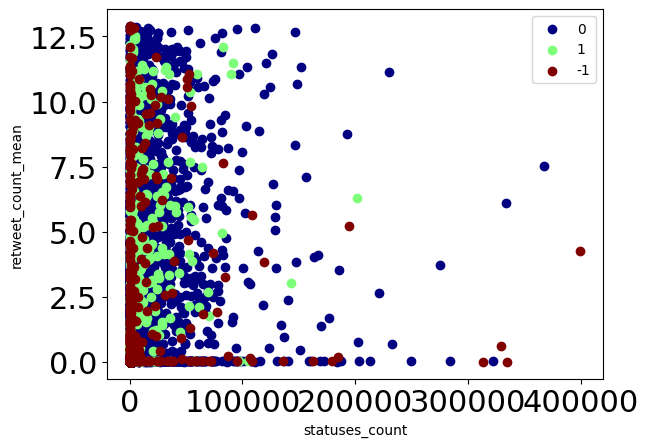

statuses_count - retweet_count_std


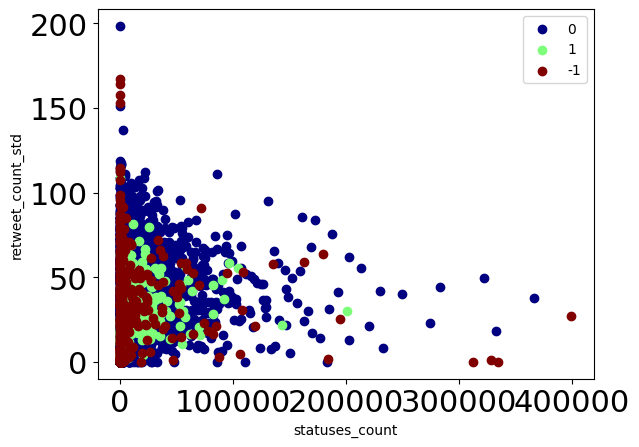

avg_length - avg_special_chars


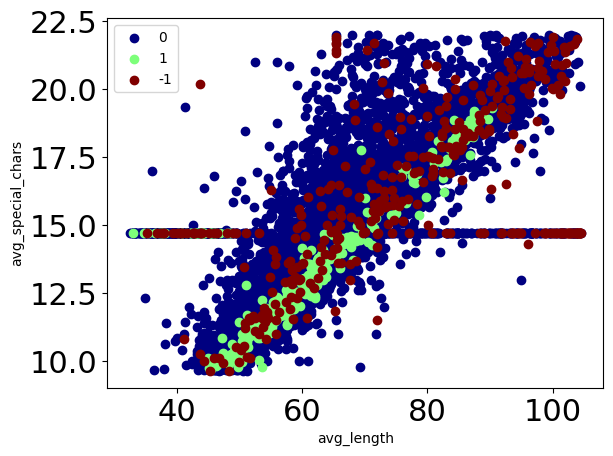

avg_length - urls_ratio


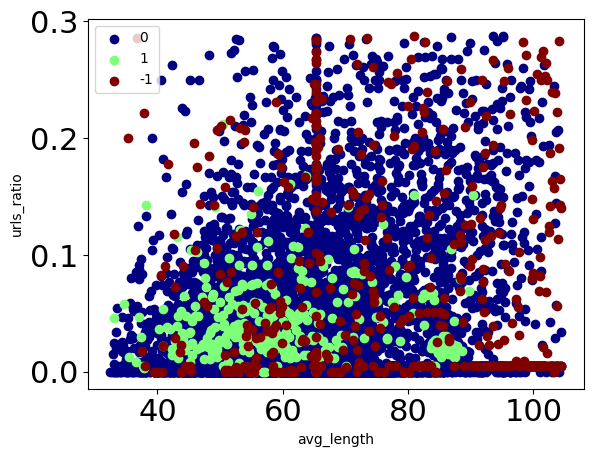

avg_length - mentions_ratio


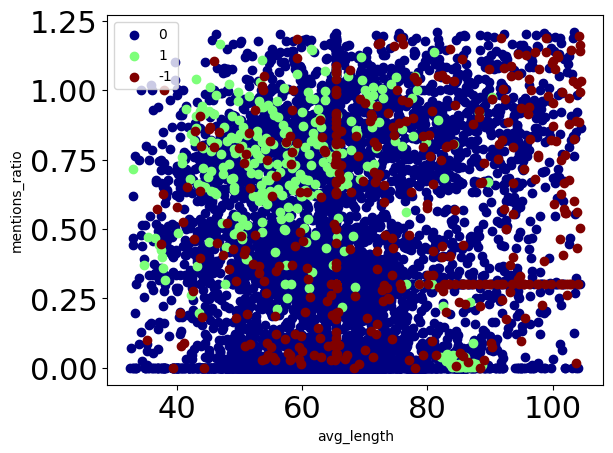

avg_length - hashtags_ratio


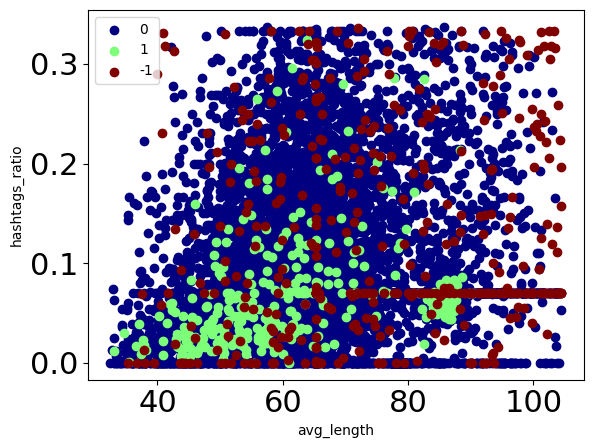

avg_length - reply_count_mean


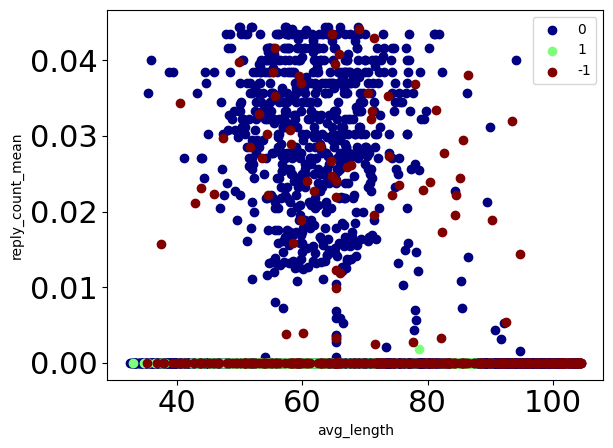

avg_length - reply_count_std


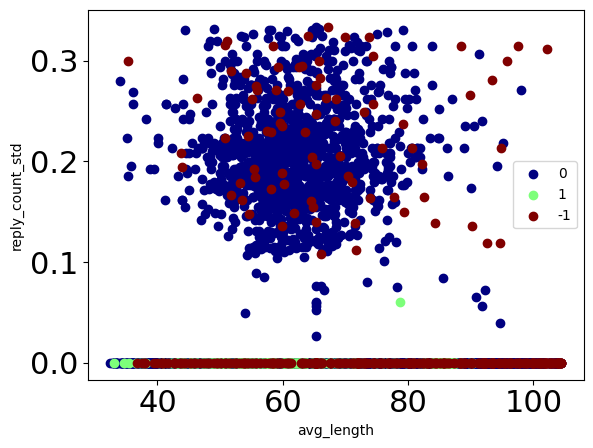

avg_length - favorite_count_mean


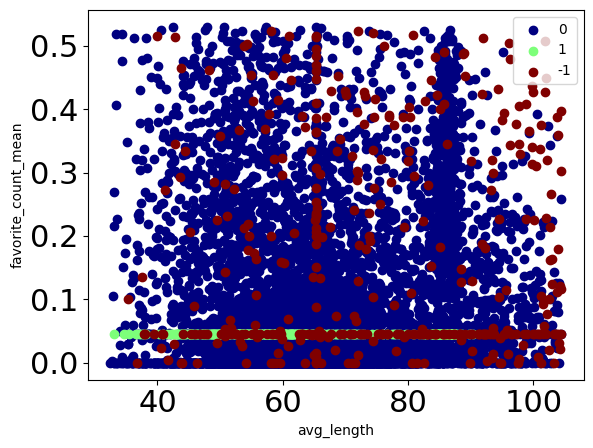

avg_length - favorite_count_std


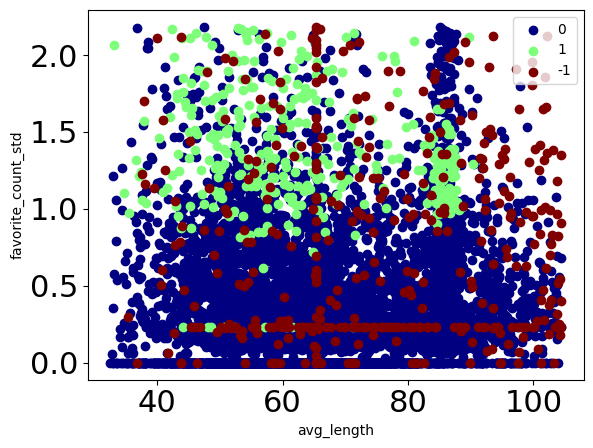

avg_length - favorite_count_entropy


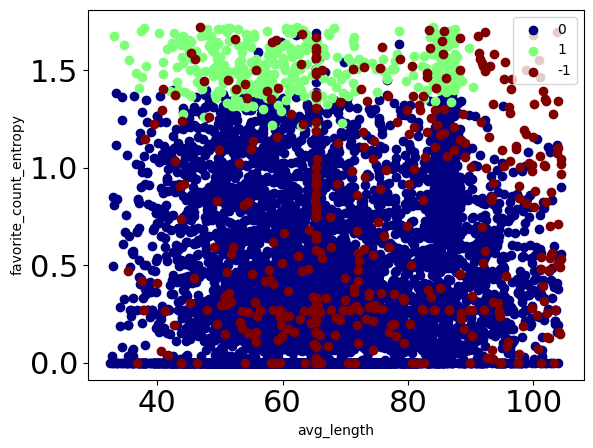

avg_length - retweet_count_mean


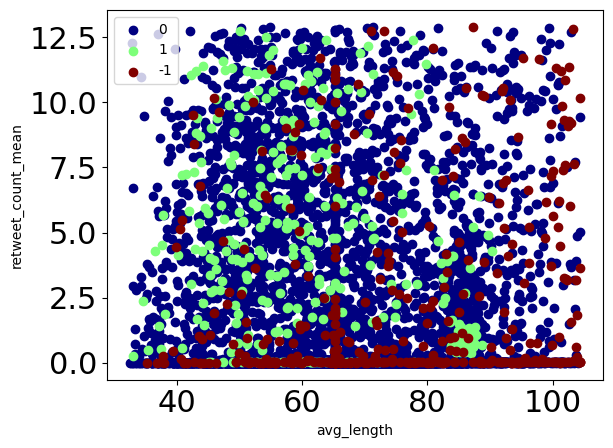

avg_length - retweet_count_std


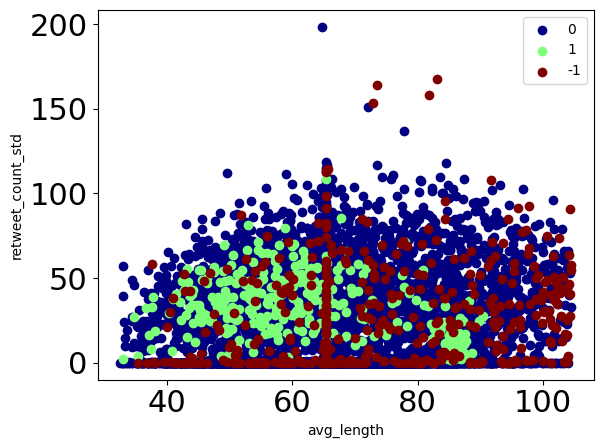

avg_special_chars - urls_ratio


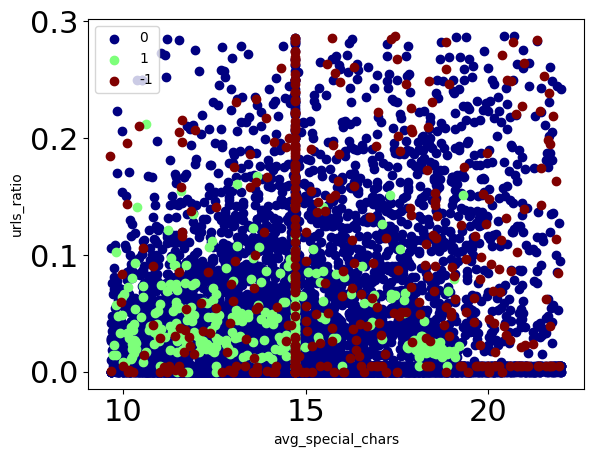

avg_special_chars - mentions_ratio


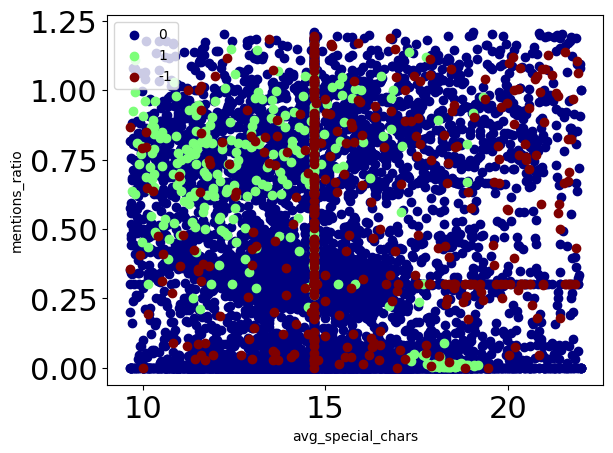

avg_special_chars - hashtags_ratio


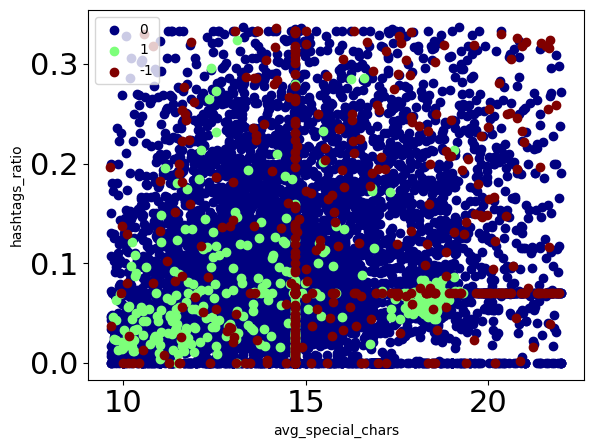

avg_special_chars - reply_count_mean


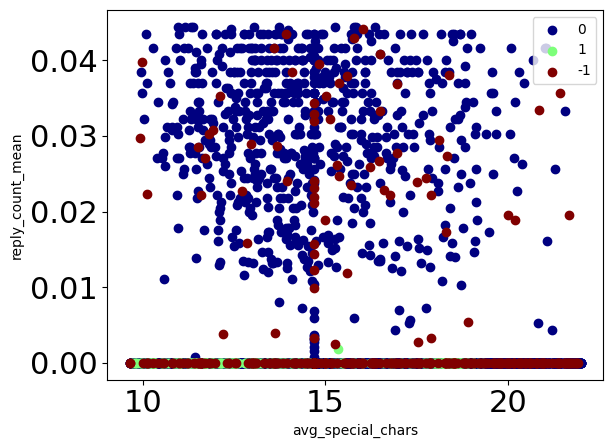

avg_special_chars - reply_count_std


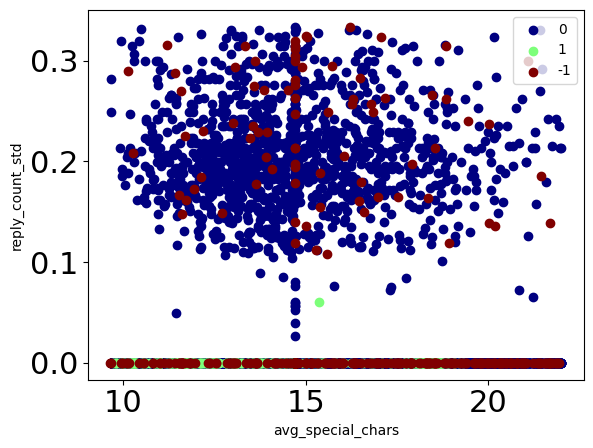

avg_special_chars - favorite_count_mean


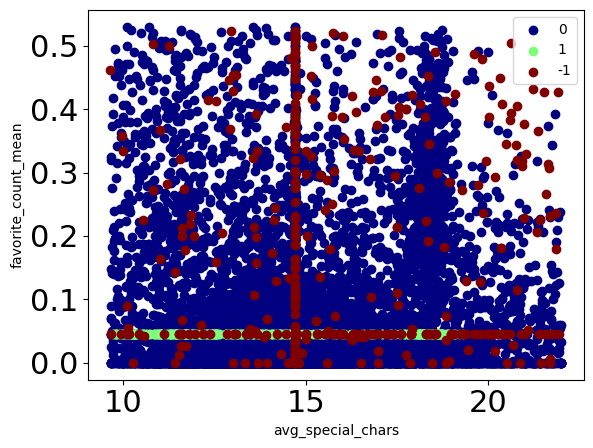

avg_special_chars - favorite_count_std


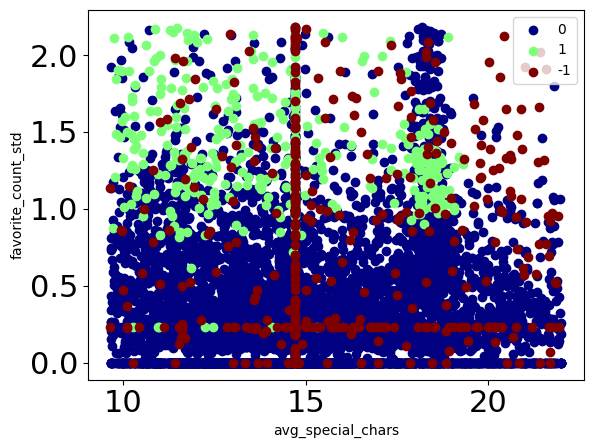

avg_special_chars - favorite_count_entropy


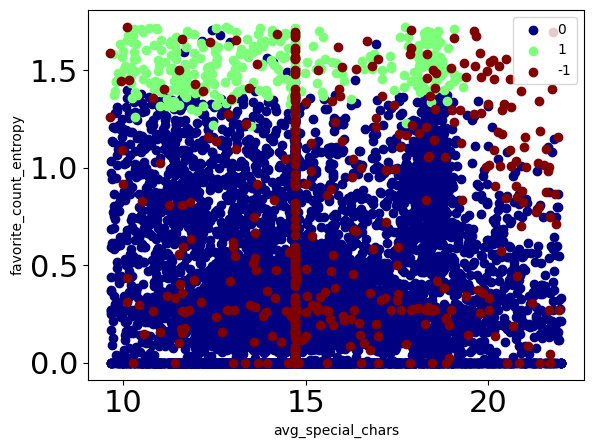

avg_special_chars - retweet_count_mean


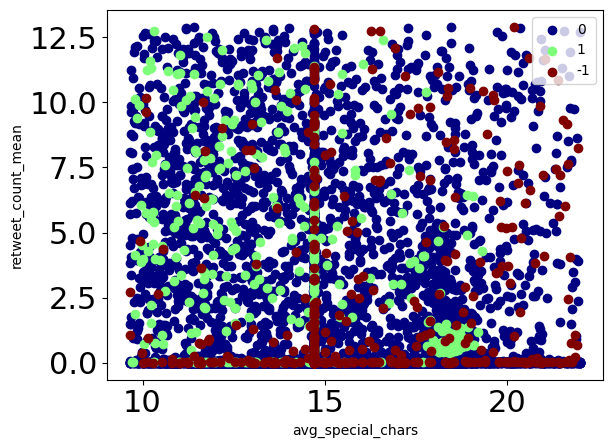

avg_special_chars - retweet_count_std


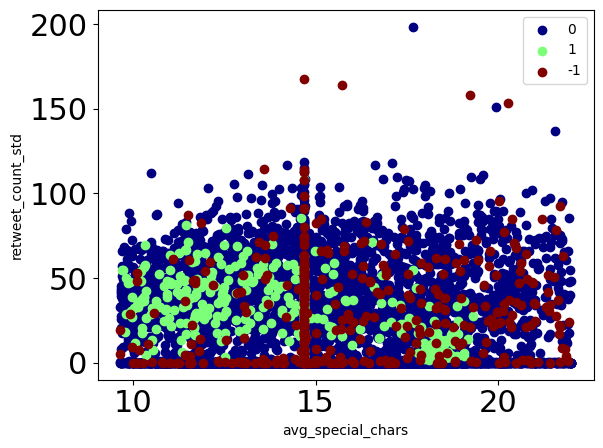

urls_ratio - mentions_ratio


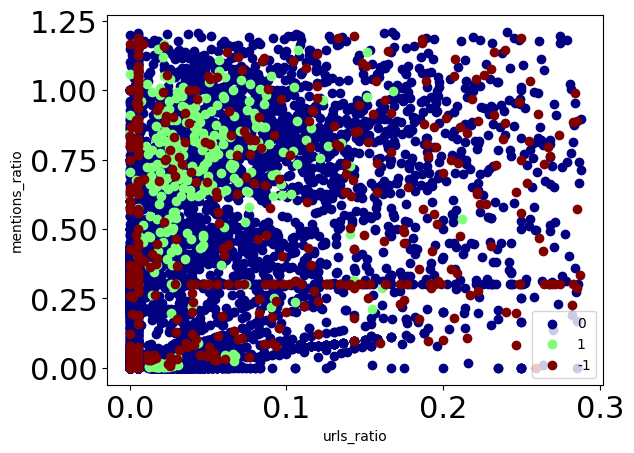

urls_ratio - hashtags_ratio


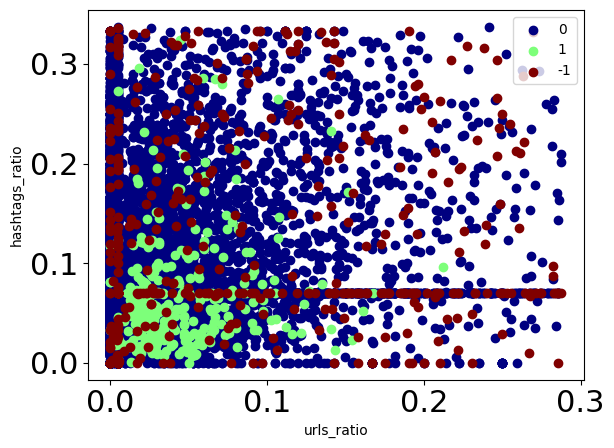

urls_ratio - reply_count_mean


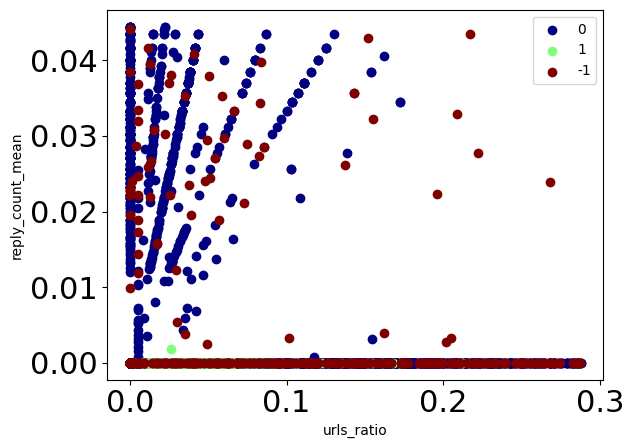

urls_ratio - reply_count_std


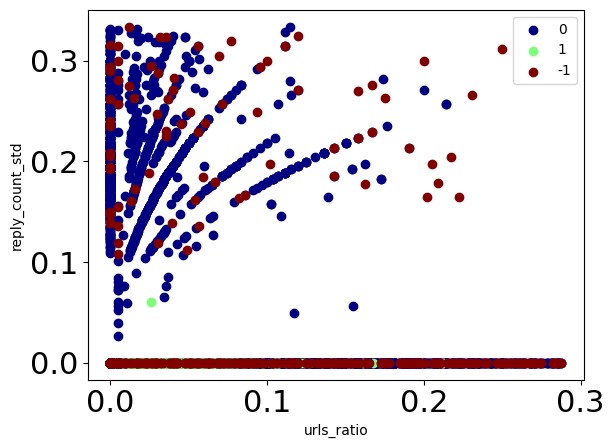

urls_ratio - favorite_count_mean


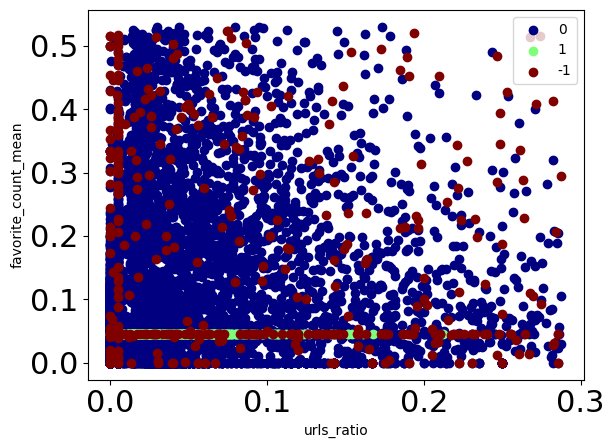

urls_ratio - favorite_count_std


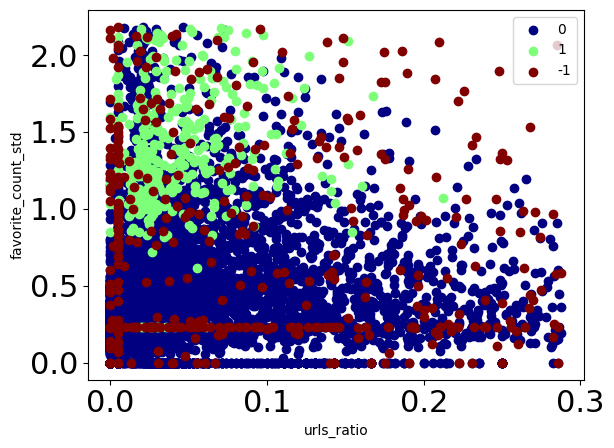

urls_ratio - favorite_count_entropy


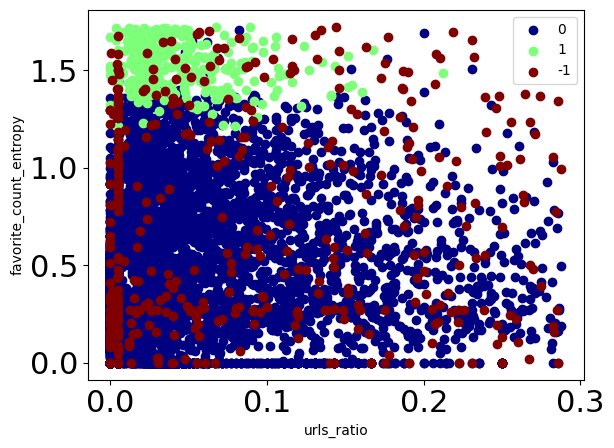

urls_ratio - retweet_count_mean


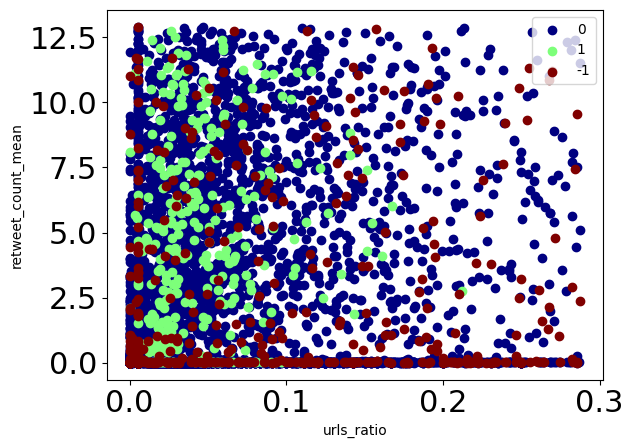

urls_ratio - retweet_count_std


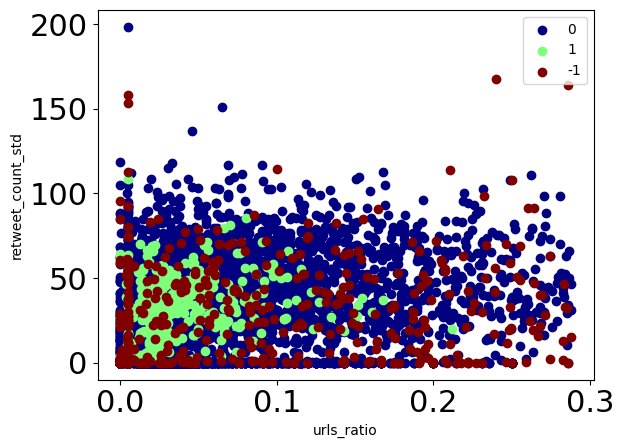

mentions_ratio - hashtags_ratio


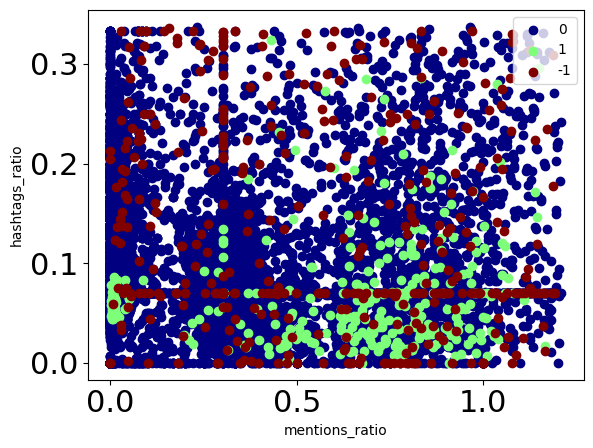

mentions_ratio - reply_count_mean


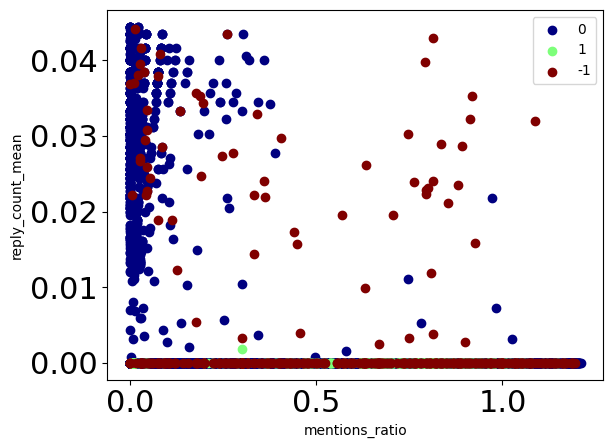

mentions_ratio - reply_count_std


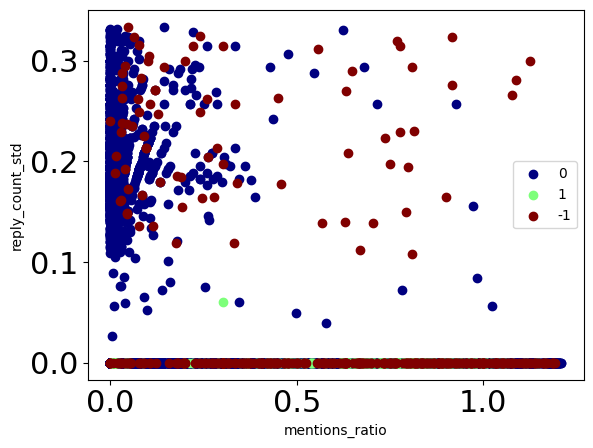

mentions_ratio - favorite_count_mean


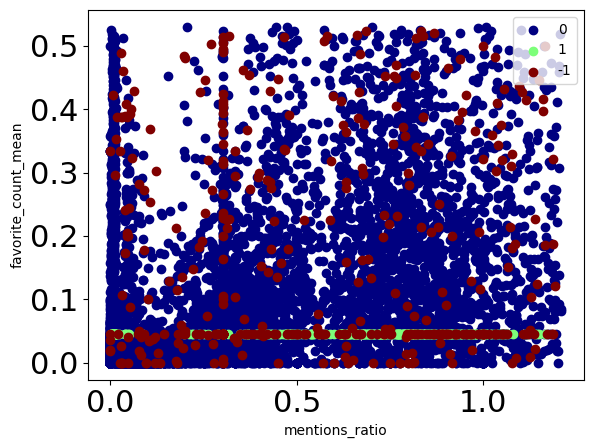

mentions_ratio - favorite_count_std


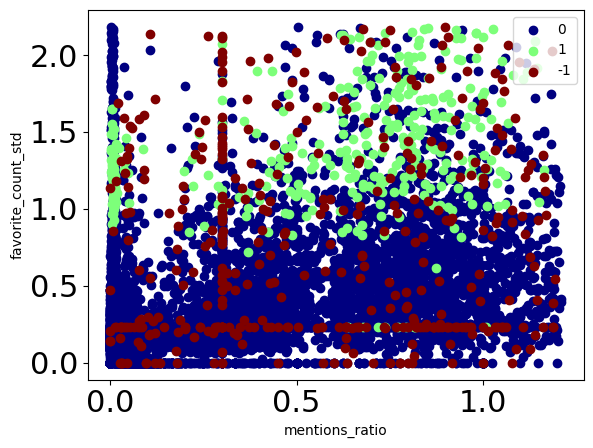

mentions_ratio - favorite_count_entropy


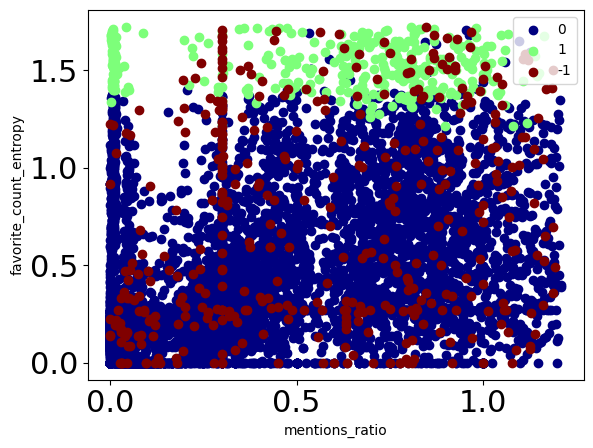

mentions_ratio - retweet_count_mean


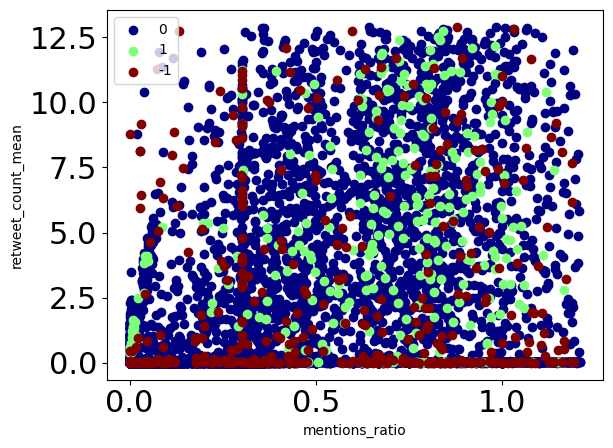

mentions_ratio - retweet_count_std


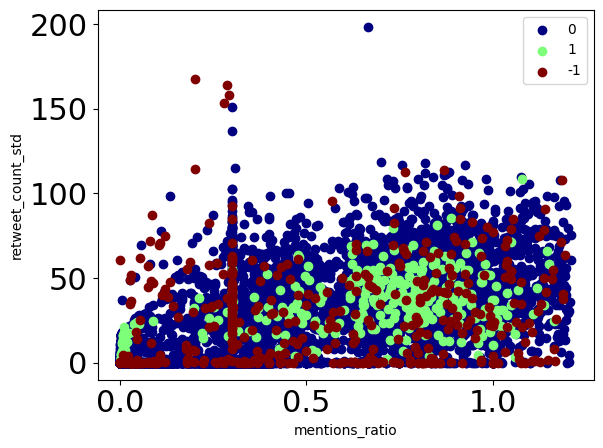

hashtags_ratio - reply_count_mean


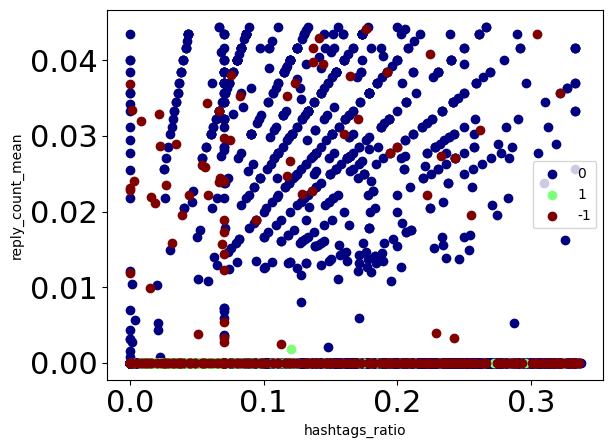

hashtags_ratio - reply_count_std


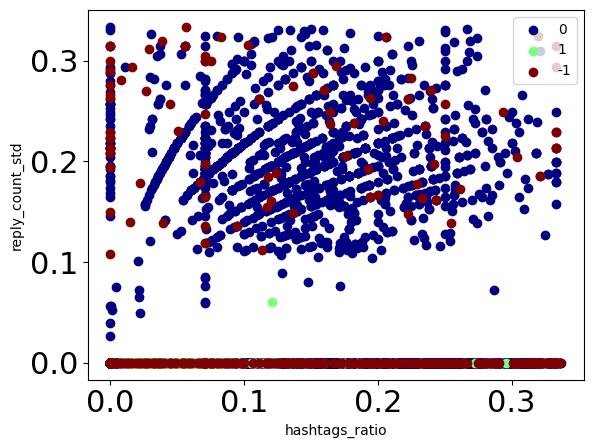

hashtags_ratio - favorite_count_mean


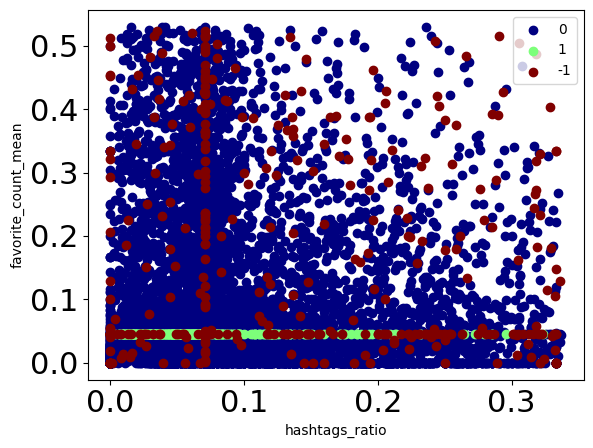

hashtags_ratio - favorite_count_std


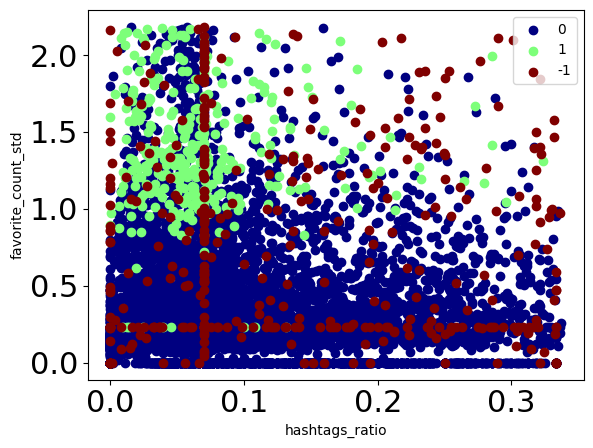

hashtags_ratio - favorite_count_entropy


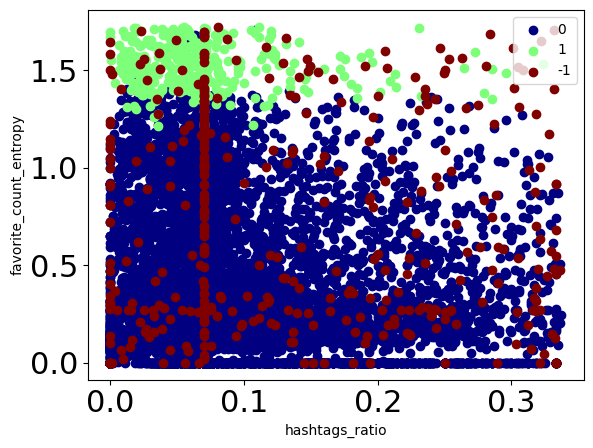

hashtags_ratio - retweet_count_mean


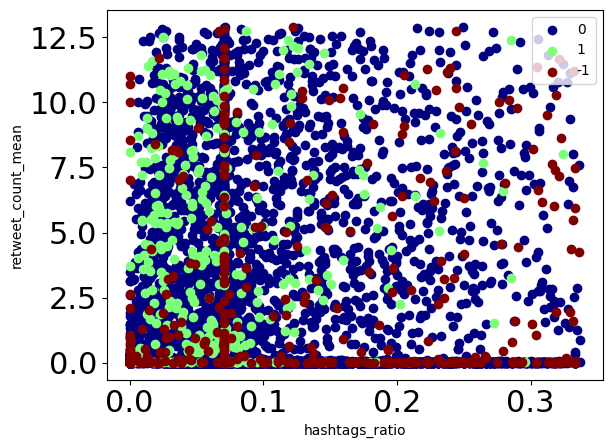

hashtags_ratio - retweet_count_std


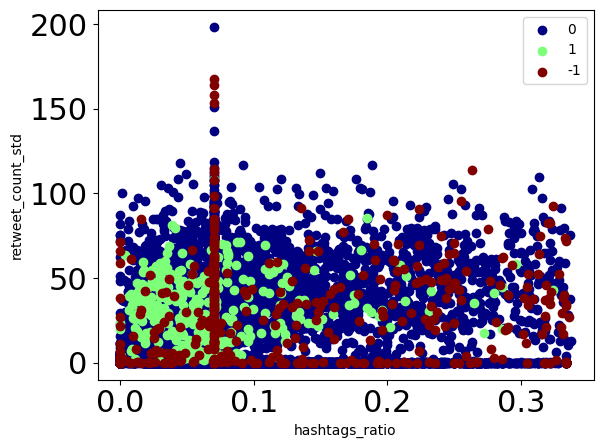

reply_count_mean - reply_count_std


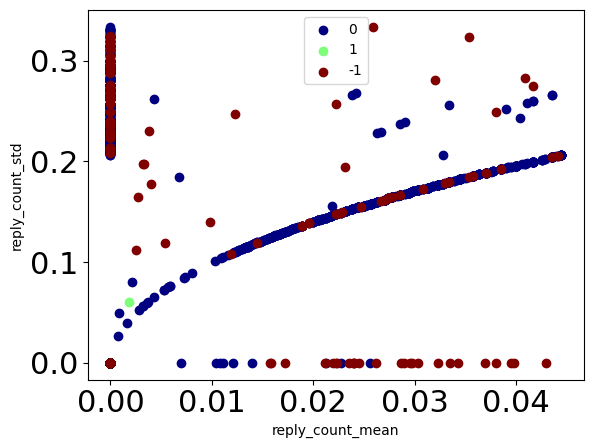

reply_count_mean - favorite_count_mean


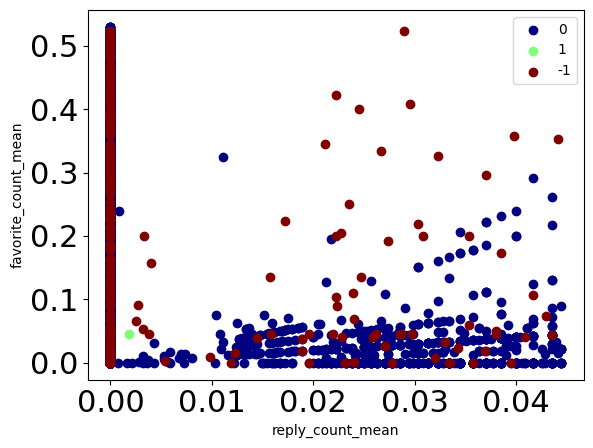

reply_count_mean - favorite_count_std


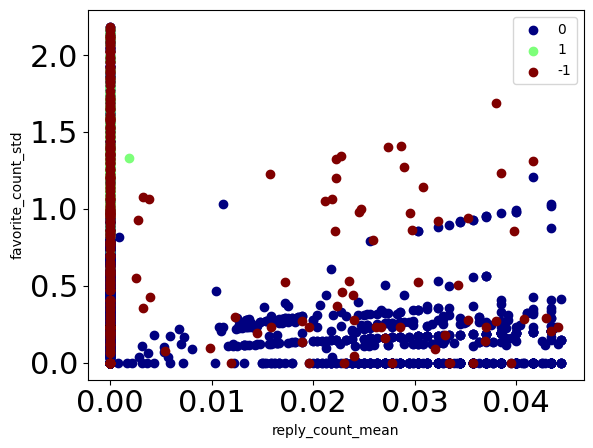

reply_count_mean - favorite_count_entropy


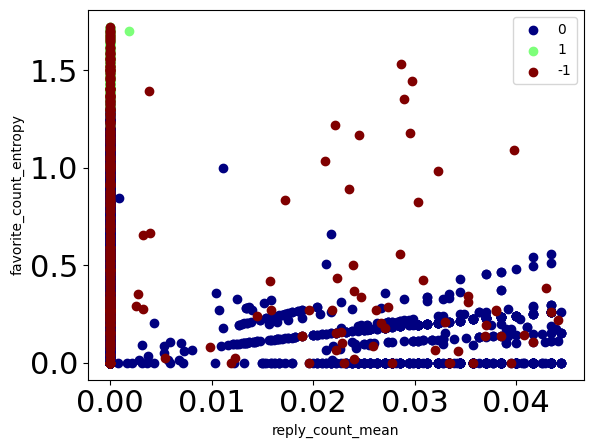

reply_count_mean - retweet_count_mean


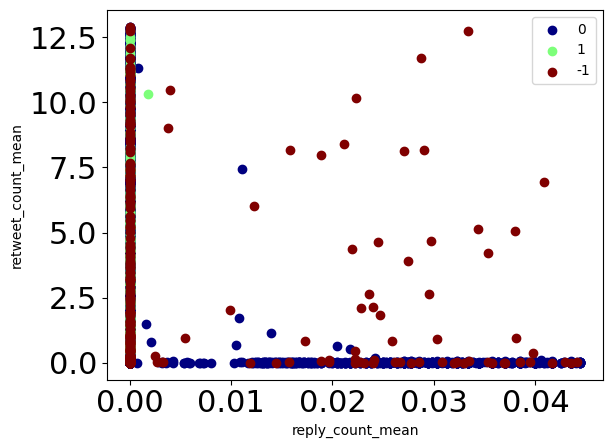

reply_count_mean - retweet_count_std


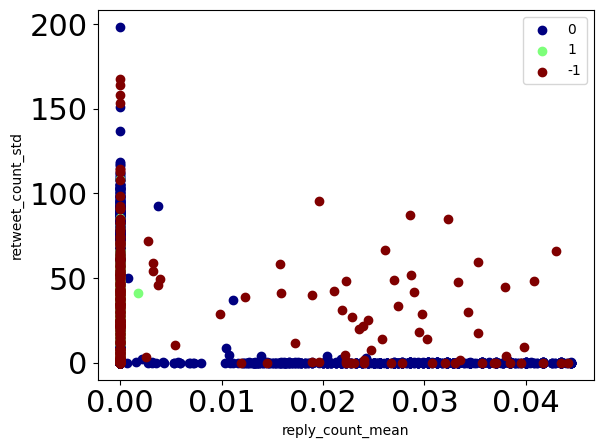

reply_count_std - favorite_count_mean


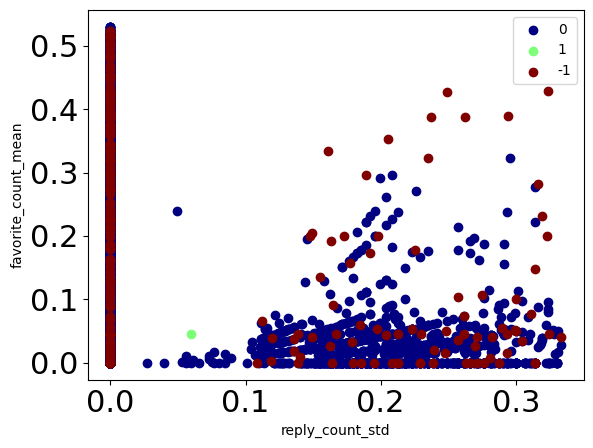

reply_count_std - favorite_count_std


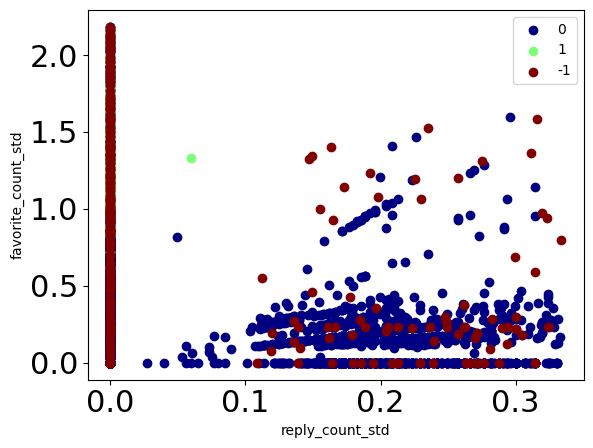

reply_count_std - favorite_count_entropy


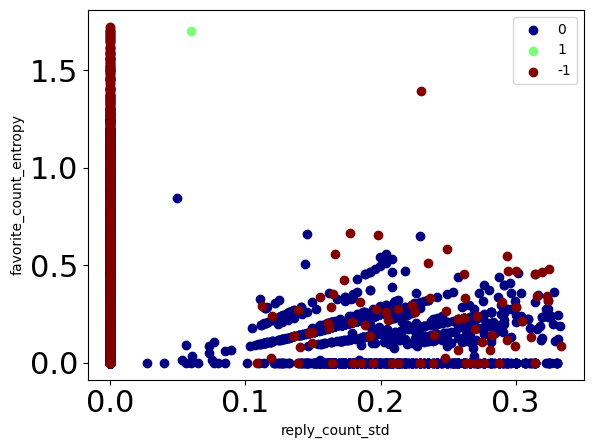

reply_count_std - retweet_count_mean


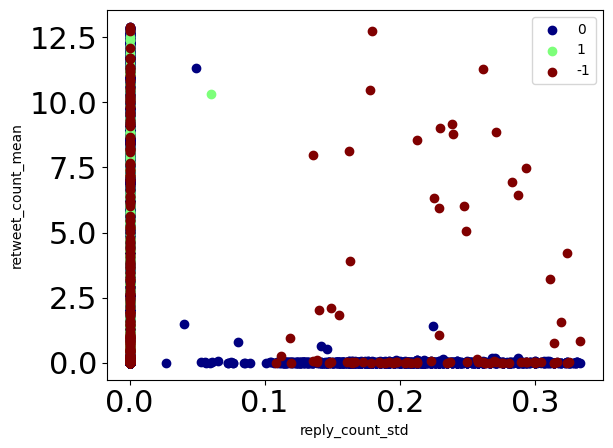

reply_count_std - retweet_count_std


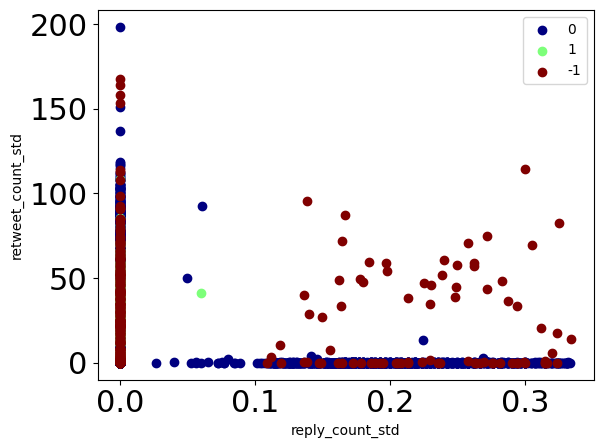

favorite_count_mean - favorite_count_std


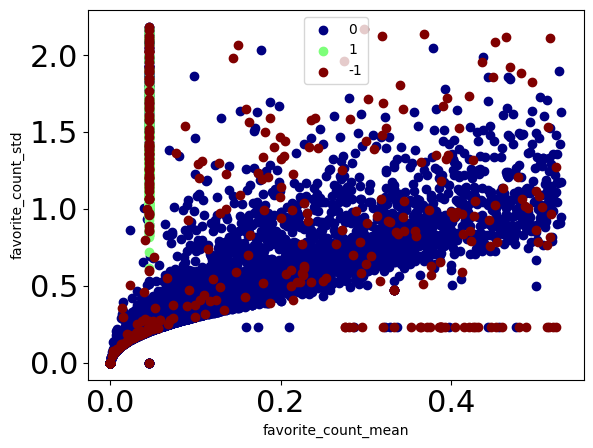

favorite_count_mean - favorite_count_entropy


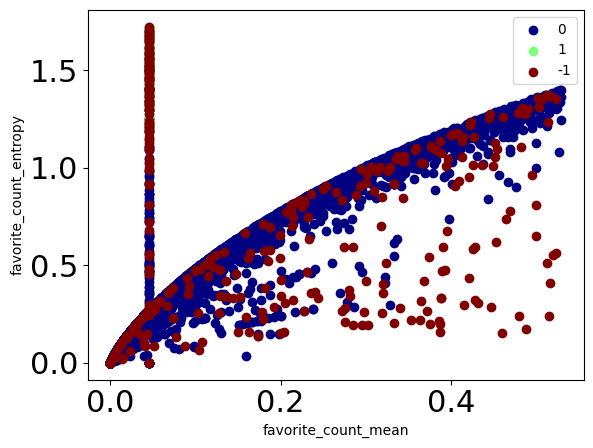

favorite_count_mean - retweet_count_mean


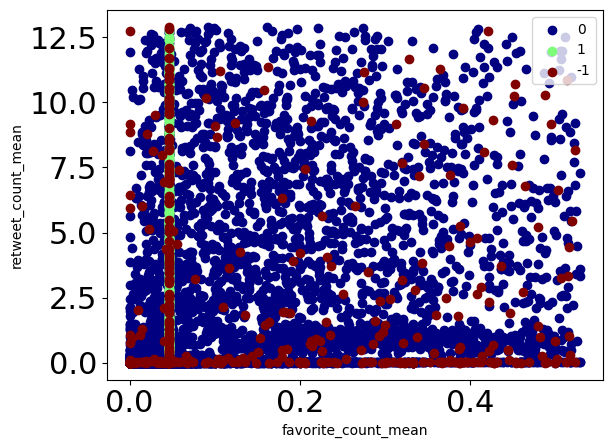

favorite_count_mean - retweet_count_std


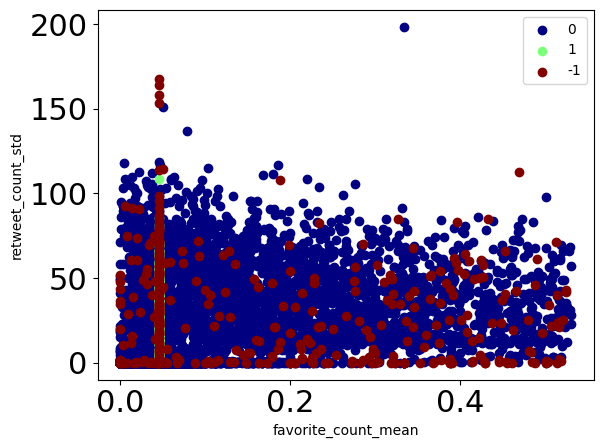

favorite_count_std - favorite_count_entropy


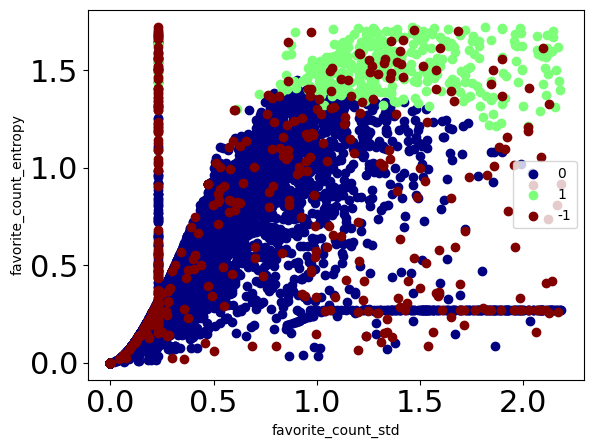

favorite_count_std - retweet_count_mean


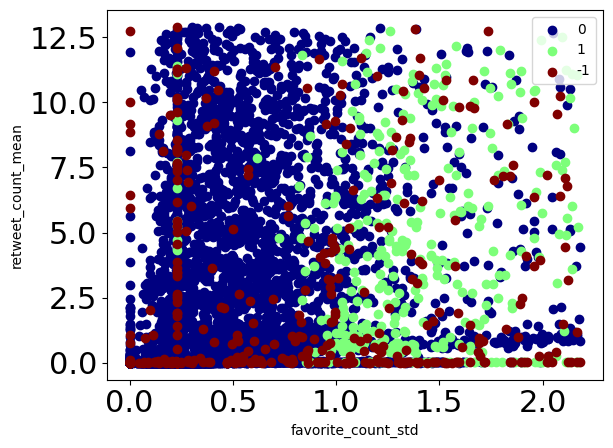

favorite_count_std - retweet_count_std


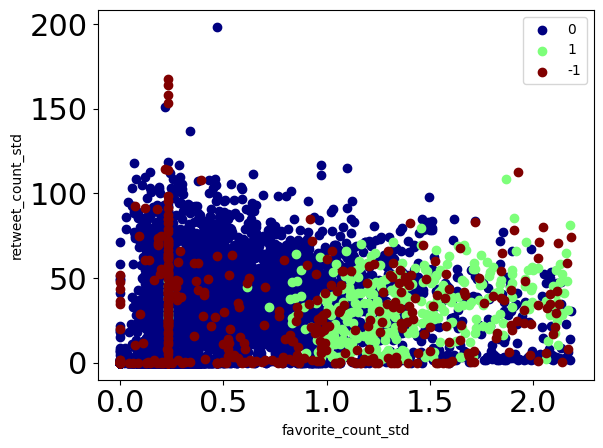

favorite_count_entropy - retweet_count_mean


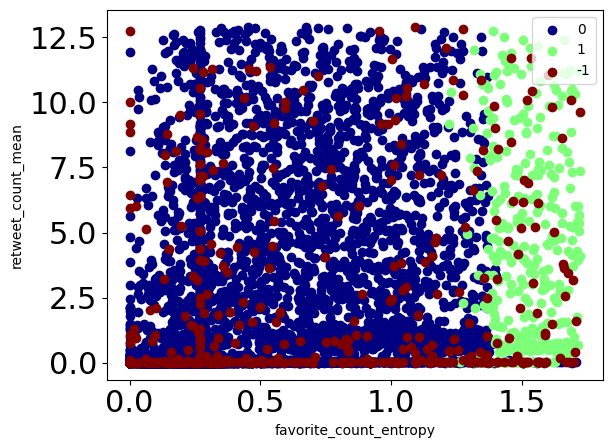

favorite_count_entropy - retweet_count_std


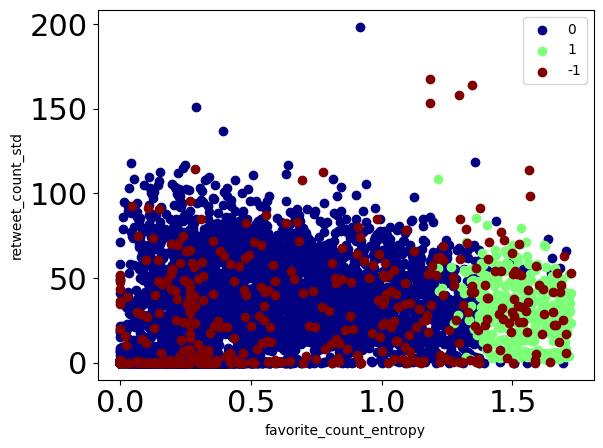

retweet_count_mean - retweet_count_std


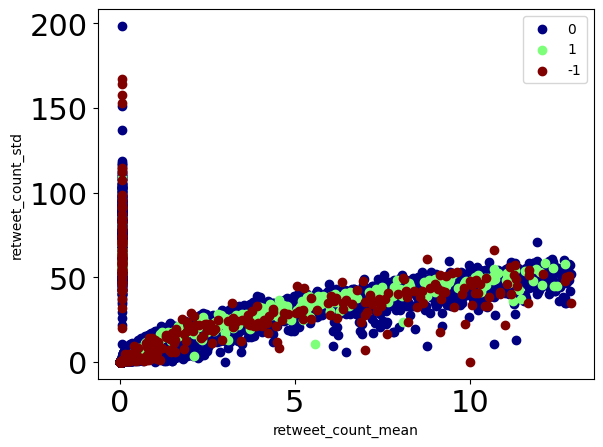

In [29]:
scatter_features_clusters(df_num, result.labels_)

### PCA

Apply PCA to visualize the scatter plot distribution of the clustered data

In [30]:
pca = PCA(n_components=2)
X_reduced = pca.fit_transform(X)

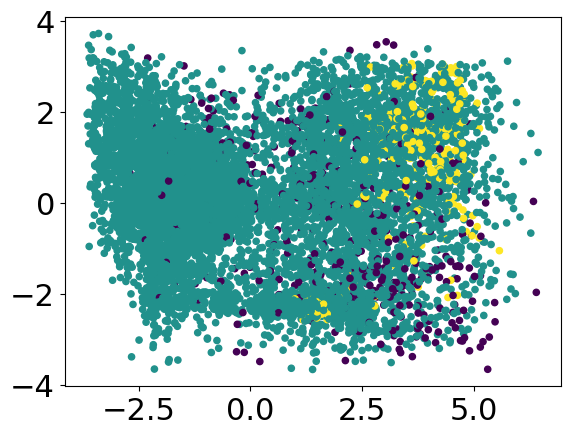

In [31]:
scatter = plt.scatter(X_reduced[:, 0], X_reduced[:, 1], c=result.labels_, s=20)
plt.tick_params(axis='both', which='major', labelsize=22)
plt.savefig("images/clustering/DBSCAN_pca.png")
plt.show()

### Evaluation DBSCAN

Print the Silouette and Separation of the method selected out.

In [48]:
print('Silhouette %s' % silhouette_score(X, result.labels_))
print('Separation %s' % metrics.davies_bouldin_score(X, result.labels_))

Silhouette 0.23800773634409955
Separation 2.6932365614034572
